## Ï¥àÍ∏∞ EDA

### Ïã†Í≥†/Ï∞®Îã® Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞ Î™ÖÏÑ∏

In [1]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import koreanize_matplotlib
from google.cloud import storage
import gcsfs

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_timelinereport.parquet"
accounts_timelinereport = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

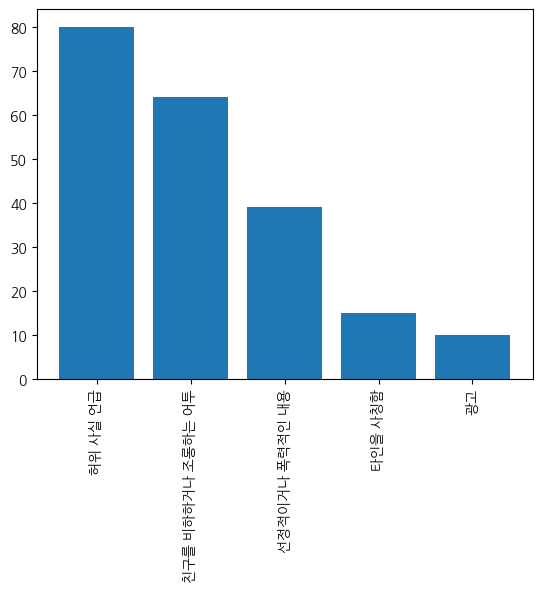

In [32]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.bar(accounts_timelinereport['reason'].value_counts().reset_index()['reason'], height=accounts_timelinereport['reason'].value_counts().reset_index()['count'])
plt.xticks(rotation=90)
plt.show()

In [3]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_blockrecord.parquet"
accounts_blockrecord = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [33]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user.parquet"
accounts_user = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [106]:
# Ïã†Í≥†ÎÇ¥Ïó≠Í≥º Ï∞®Îã®ÎÇ¥Ïó≠(accounts_blockrecord) Í∞ÑÏùò Í¥ÄÍ≥Ñ Ï°∞ÏÇ¨
df_merge_block = accounts_timelinereport.merge(accounts_blockrecord, left_on=['user_id','reported_user_id'], right_on=['user_id','block_user_id'],suffixes=('_report', '_block'))
df_merge_block

reason_report   created_at_report  reported_user_id  user_id  \
0      ÌóàÏúÑ ÏÇ¨Ïã§ Ïñ∏Í∏â 2023-05-12 02:48:56           1150928  1137878   

   user_question_record_id reason_block    created_at_block  block_user_id  
0                 26226336      Î™®Î•¥Îäî ÏÇ¨ÎûåÏûÑ 2023-05-14 02:55:26        1150928

In [ ]:
# block_user_id_list Ïó¨Îü¨ ÌñâÏúºÎ°ú explode
accounts_user_nan = accounts_user.replace('[]', np.nan)
accounts_user_dropna = accounts_user_nan.dropna()
accounts_user_dropna['block_user_id_list'] = accounts_user_dropna['block_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_explode = accounts_user_dropna[['id','block_user_id_list']].explode('block_user_id_list')
accounts_user_explode

/tmp/ipykernel_226/177197795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_user_dropna['block_user_id_list'] = accounts_user_dropna['block_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


id block_user_id_list
162      837615             839155
208      837689             834325
285      837784             834325
287      837786            1158705
287      837786            1108926
...         ...                ...
668524  1574460            1576077
668524  1574460            1576581
668575  1574512            1005876
670207  1576284            1349412
672023  1578333            1578352

[7687 rows x 2 columns]

In [125]:
# Ïã†Í≥†ÎÇ¥Ïó≠Í≥º Ï∞®Îã®ÎÇ¥Ïó≠(block_user_id_list) Í∞ÑÏùò Í¥ÄÍ≥Ñ Ï°∞ÏÇ¨
df_merge_ban = accounts_timelinereport.merge(accounts_user_explode, left_on=['user_id','reported_user_id'], right_on=['id','block_user_id_list'],suffixes=('_report', '_ban'))
df_merge_ban

Empty DataFrame
Columns: [reason, created_at, reported_user_id, user_id, user_question_record_id, id, block_user_id_list]
Index: []

In [ ]:
# hide_user_id_list Ïó¨Îü¨ ÌñâÏúºÎ°ú explode
accounts_user_dropna['hide_user_id_list'] = accounts_user_dropna['hide_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_explode = accounts_user_dropna[['id','hide_user_id_list']].explode('hide_user_id_list')
accounts_user_explode

/tmp/ipykernel_226/1497952159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_user_dropna['hide_user_id_list'] = accounts_user_dropna['hide_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


id hide_user_id_list
162      837615            837661
208      837689            838168
208      837689            837745
285      837784            837684
285      837784            839155
...         ...               ...
668575  1574512           1129856
670207  1576284           1349412
672023  1578333           1578352
672023  1578333           1578399
672023  1578333           1578494

[47084 rows x 2 columns]

In [127]:
# Ïã†Í≥†ÎÇ¥Ïó≠Í≥º Ïà®ÍπÄÎÇ¥Ïó≠(hide_user_id_list) Í∞ÑÏùò Í¥ÄÍ≥Ñ Ï°∞ÏÇ¨
df_merge_hide = accounts_timelinereport.merge(accounts_user_explode, left_on=['user_id','reported_user_id'], right_on=['id','hide_user_id_list'],suffixes=('_report', '_hide'))
df_merge_hide

Empty DataFrame
Columns: [reason, created_at, reported_user_id, user_id, user_question_record_id, id, hide_user_id_list]
Index: []

In [161]:
ban_status_total = accounts_user['ban_status'].value_counts().reset_index()
ban_status_total

ban_status   count
0          N  668432
1          W    7855
2         NB     608
3         RB     190

In [155]:
import matplotlib.pyplot as plt

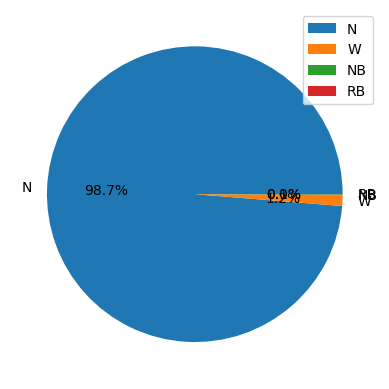

In [172]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(ban_status_total['count'], labels=ban_status_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [173]:
# Ï¥ù Ïã†Í≥† ÌöüÏàòÏôÄ ban_status Í∞ÑÏùò Í¥ÄÍ≥Ñ

report_cnt = accounts_timelinereport['reported_user_id'].value_counts().reset_index()
ban_status = accounts_user[['id','ban_status']]
merge_report_ban = pd.merge(report_cnt, ban_status, left_on='reported_user_id', right_on='id')
report_ban_total = merge_report_ban['ban_status'].value_counts().reset_index()

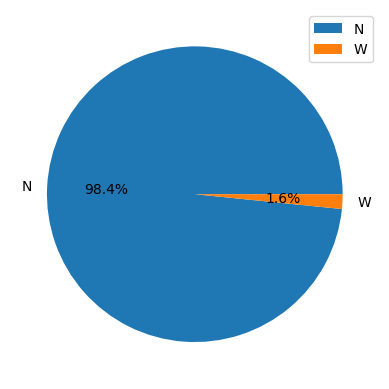

In [174]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(report_ban_total['count'], labels=report_ban_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [175]:
# Ï¥ù Ï∞®Îã® ÌöüÏàòÏôÄ ban_status Í∞ÑÏùò Í¥ÄÍ≥Ñ

block_cnt = accounts_blockrecord['block_user_id'].value_counts().reset_index()
ban_status = accounts_user[['id','ban_status']]
merge_block_ban = pd.merge(block_cnt, ban_status, left_on='block_user_id', right_on='id')
block_ban_total = merge_block_ban['ban_status'].value_counts().reset_index()

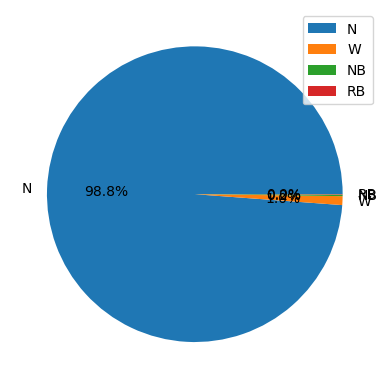

In [ ]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(block_ban_total['count'], labels=block_ban_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [150]:
merge_block_ban[merge_block_ban['ban_status']=='NB']['count'].value_counts()

count
1    23
4     1
3     1
2     1
Name: count, dtype: int64

In [151]:
merge_block_ban[merge_block_ban['ban_status']=='RB']['count'].value_counts()

count
1     5
2     2
11    1
Name: count, dtype: int64

### ÏπúÍµ¨Îäî ÏåçÎ∞©ÏùºÍπå?

In [6]:
accounts_user_frnd = accounts_user.copy()
accounts_user_frnd['friend_id_list'] = accounts_user_frnd['friend_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_frnd_explode = accounts_user_frnd[['id','friend_id_list']].explode('friend_id_list')
accounts_user_frnd_explode

id friend_id_list
0        831956        1292473
0        831956         913158
0        831956        1488461
0        831956        1064695
0        831956        1043565
...         ...            ...
677082  1583731        1583673
677083  1583732        1583673
677083  1583732        1583730
677083  1583732        1583731
677084  1583733            NaN

[36110260 rows x 2 columns]

In [7]:
accounts_user_frnd_explode = accounts_user_frnd_explode.dropna()
accounts_user_frnd_explode.shape

(36107386, 2)

In [8]:
accounts_user_frnd_explode = accounts_user_frnd_explode.reset_index(drop=True)

In [ ]:
pairs = set(zip(accounts_user_frnd_explode['id'], accounts_user_frnd_explode['friend_id_list']))

# ÏåçÎ∞©Ïù¥Ïñ¥Ïïº ÌïòÎäî Î∞òÎåÄ Î∞©Ìñ• Ïåç ÏÉùÏÑ±
reverse_pairs = set((b, a) for (a, b) in pairs)

# ÏåçÎ∞© ÏïÑÎãå Í≤ÉÎßå Ï∂îÏ∂ú
non_mutual = pairs - reverse_pairs

In [12]:
print("ÏåçÎ∞© ÏïÑÎãå Í¥ÄÍ≥ÑÏùò Í∞úÏàò:")
print(len(non_mutual))

ÏåçÎ∞© ÏïÑÎãå Í¥ÄÍ≥ÑÏùò Í∞úÏàò:
183902


### Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í≤ÄÏÇ¨

In [ ]:
# GCS ÌååÏùº ÏãúÏä§ÌÖú Í∞ùÏ≤¥ ÏÉùÏÑ±
fs = gcsfs.GCSFileSystem()

# GCS Î≤ÑÌÇ∑ ÎÇ¥ Î™®Îì† parquet ÌååÏùº Í≤ΩÎ°ú Í∞ÄÏ†∏Ïò§Í∏∞
parquet_paths = fs.glob("sprintda05_final_project/**/*.parquet")

# ÌååÏùºÎ™Ö Í∏∞Î∞òÏúºÎ°ú DataFrame ÎîïÏÖîÎÑàÎ¶¨ ÎßåÎì§Í∏∞
dataframes = {}

for path in parquet_paths:
    df = pd.read_parquet(f"gs://{path}", engine="pyarrow")
    if 'id' in df.columns:
        df = df.drop(columns='id')
    
    # ÌååÏùºÎ™Ö(ÌôïÏû•Ïûê Ìè¨Ìï®)ÏùÑ keyÎ°ú ÏÇ¨Ïö©
    filename = path.split("/")[-1]
    dataframes[filename] = df

In [8]:
# enumerateÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞
for idx, (filename, df) in enumerate(dataframes.items()):
    print(f"[{idx}] {filename}: {df.shape}")
    # ÏõêÌïòÎäî ÏûëÏóÖ ÏàòÌñâ
    # print(df.replace('[]', np.nan).isna().sum())
    for col in df.columns:
        count = (df[col] == '[]').sum()
        print(f"{col}\t{count}")
    print()

[0] device_properties.parquet: (252380, 3)
device_id	0
device_model	0
device_vendor	0

[1] hackle_events.parquet: (11441319, 10)
event_id	0
event_datetime	0
event_key	0
session_id	0
item_name	0
page_name	0
friend_count	0
votes_count	0
heart_balance	0
question_id	0

[2] hackle_properties.parquet: (525350, 7)
session_id	0
user_id	0
language	0
osname	0
osversion	0
versionname	0
device_id	0

[3] user_properties.parquet: (230819, 5)
user_id	0
class	0
gender	0
grade	0
school_id	0

[4] accounts_attendance.parquet: (349637, 2)
attendance_date_list	20945
user_id	0

[5] accounts_blockrecord.parquet: (19482, 4)
reason	0
created_at	0
block_user_id	0
user_id	0

[6] accounts_failpaymenthistory.parquet: (163, 4)
productId	0
phone_type	0
created_at	0
user_id	0

[7] accounts_friendrequest.parquet: (17147175, 5)
status	0
created_at	0
updated_at	0
receive_user_id	0
send_user_id	0

[8] accounts_group.parquet: (84515, 3)
grade	0
class_num	0
school_id	0

[9] accounts_nearbyschool.parquet: (59500, 3)
distanc

## Ï†ÑÏ≤òÎ¶¨

### accounts_user

In [15]:
import pandas as pd
import ast
from google.cloud import storage

In [10]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user.parquet"
df = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [11]:
df.shape

(677085, 16)

In [ ]:
# accounts_user['point'] IQR*3 Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨
point_iqr = df['point'].quantile(.75) - df['point'].quantile(.25)
point_upper_bound = df['point'].quantile(.75) + 3 * point_iqr
df = df[df['point']<=point_upper_bound]

In [13]:
df.shape

(663207, 16)

In [17]:
# len(accounts_user['friend_id_list']) ÏÉÅÏúÑ 1% Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨
df['friend_cnt'] = len(df['friend_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x))
friend_upper_bound = df['friend_cnt'].quantile(.99)
df = df[df['friend_cnt']<=friend_upper_bound]

In [18]:
df.shape

(663207, 17)

## Ï£ºÏ†ú ÏÑ†Ï†ï EDA

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionpiece.parquet"
polls_questionpiece = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [26]:
is_voted = polls_questionpiece['is_voted'].value_counts().reset_index()

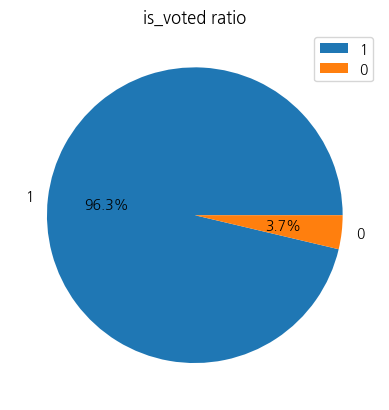

In [39]:
# polls_questionpiece -> is_voted ÎπÑÏú®
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(is_voted['count'], labels=is_voted['is_voted'], autopct='%1.1f%%',)
ax.legend()
plt.title('is_voted ratio')
plt.show()

In [ ]:
is_skipped = polls_questionpiece['is_skipped'].value_counts().reset_index()

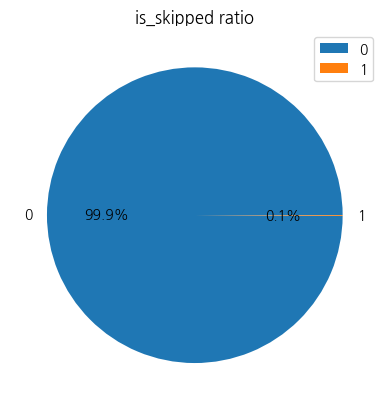

In [40]:
# polls_questionpiece -> is_skipped ÎπÑÏú®
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(is_skipped['count'], labels=is_skipped['is_skipped'], autopct='%1.1f%%',)
ax.legend()
plt.title('is_skipped ratio')
plt.show()

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionset.parquet"
polls_questionset = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [37]:
poll_status = polls_questionset['status'].value_counts().reset_index()
poll_status

status   count
0      F  153411
1      O    4407
2      C     566

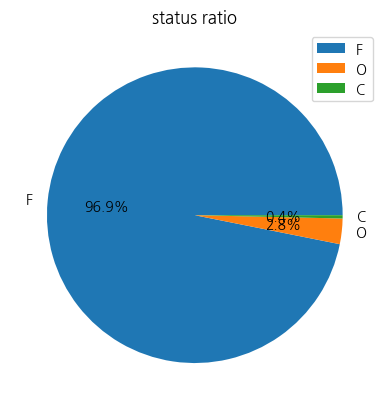

In [42]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(poll_status['count'], labels=poll_status['status'], autopct='%1.1f%%',)
ax.legend()
plt.title('status ratio')
plt.show()

In [44]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionset.parquet"
polls_questionset = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [ ]:
polls_questionset['created_at']

question_piece_id_list        opening_time  \
0       [998458, 998459, 998460, 998461, 998462, 99846... 2023-04-28 12:27:22   
1       [998588, 998589, 998590, 998591, 998592, 99859... 2023-04-28 12:28:07   
2       [998689, 998691, 998693, 998695, 998697, 99869... 2023-04-28 12:28:38   
3       [998688, 998690, 998692, 998694, 998696, 99869... 2023-04-28 12:28:38   
4       [998768, 998769, 998770, 998771, 998772, 99877... 2023-04-28 12:28:57   
...                                                   ...                 ...   
158379  [208383291, 208383292, 208383293, 208383294, 2... 2024-05-05 14:46:27   
158380  [208384201, 208384202, 208384203, 208384204, 2... 2024-05-06 11:38:20   
158381  [208384951, 208384952, 208384953, 208384954, 2... 2024-05-07 00:55:00   
158382  [208385211, 208385212, 208385213, 208385214, 2... 2024-05-07 12:09:08   
158383  [208385221, 208385222, 208385223, 208385224, 2... 2024-05-07 12:12:30   

       status          created_at  user_id  
0           F 2023-04-28 12:27:23   849436  
1           F 2023-04-28 12:28:07   849438  
2           F 2023-04-28 12:28:38   847375  
3           F 2023-04-28 12:28:38   849446  
4           F 2023-04-28 12:28:57   849477  
...       ...                 ...      ...  
158379      C 2024-05-05 14:06:27  1251933  
158380      C 2024-05-06 10:58:20   876072  
158381      C 2024-05-07 00:15:00  1208878  
158382      C 2024-05-07 11:29:08  1001607  
158383      C 2024-05-07 11:32:30   945560  

[158384 rows x 5 columns]

In [47]:
created_at = polls_questionset['created_at'].value_counts().reset_index()

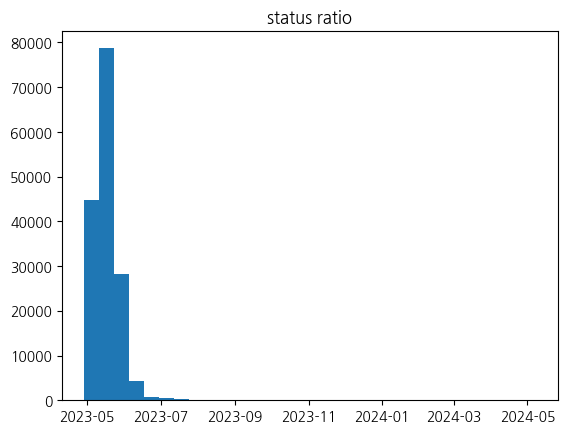

In [54]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.hist(polls_questionset['created_at'], bins=30)
plt.title('status ratio')
plt.show()

In [55]:
polls_questionset['created_at']

0        2023-04-28 12:27:23
1        2023-04-28 12:28:07
2        2023-04-28 12:28:38
3        2023-04-28 12:28:38
4        2023-04-28 12:28:57
                 ...        
158379   2024-05-05 14:06:27
158380   2024-05-06 10:58:20
158381   2024-05-07 00:15:00
158382   2024-05-07 11:29:08
158383   2024-05-07 11:32:30
Name: created_at, Length: 158384, dtype: datetime64[ns]

## Î∂ÑÏÑù Ï§ÄÎπÑ

### hackle Ï†ÑÏ≤òÎ¶¨ ÌôïÏù∏

In [3]:
gcs_parquet_path = "gs://sprintda05_final_project/hackle/hackle_events.parquet"
hackle_events = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [4]:
hackle_events.columns

Index(['event_id', 'event_datetime', 'event_key', 'session_id', 'id',
       'item_name', 'page_name', 'friend_count', 'votes_count',
       'heart_balance', 'question_id'],
      dtype='object')

In [13]:
print(hackle_events[hackle_events['event_key']=='button']['event_id'].count())
print(hackle_events[hackle_events['event_key']=='click_appbar_setting']['event_id'].count())
print(hackle_events['event_id'].count())

428
26685
11441319


In [ ]:
hackle_events['event_id'] == hackle_events['id']

### accounts_user Ï†ÑÏ≤òÎ¶¨ ÌôïÏù∏

In [15]:
gcs_parquet_path = "gs://sprintda05_final_project/processed/accounts_user_processed.parquet"
accounts_user_processed = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [18]:
accounts_user_processed['id'].astype('int')

0          831956
1          831962
2          832151
3          832340
4          832520
           ...   
677080    1583729
677081    1583730
677082    1583731
677083    1583732
677084    1583733
Name: id, Length: 677085, dtype: int64

### accounts_user_contact ÌÖåÏù¥Î∏î ÎÑ§Ìä∏ÏõåÌÅ¨ Ïù¥Î°† Ï†ÅÏö©

In [2]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user_contacts.parquet"
accounts_user_contacts = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [3]:
accounts_user_contacts.head()

id  contacts_count invite_user_id_list  user_id
0    259              30                  []  1167696
1   1756              79                  []   863169
2  13742              21            [854615]   857205
3  13754              29                  []   851431
4  13756              28            [849318]   855476

## Ï¥àÍ∏∞ Î∂ÑÏÑù

In [1]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from google.cloud import storage
import gcsfs
from collections import defaultdict

### 0. ÌååÏùº ÏÑ∏ÌåÖ

#### Î∞îÎ°ú Î∂àÎü¨ÏôÄÏÑú merge (kernel crush Ïù¥Ïäà ÏûàÏùå)

In [ ]:
# GCS Î≤ÑÌÇ∑ ÎÇ¥ Î™®Îì† parquet ÌååÏùº Í∞ÄÏ†∏Ïò§Í∏∞
fs = gcsfs.GCSFileSystem()
parquet_paths = fs.glob("sprintda05_final_project/**/*.parquet")

# 1. Ï†ÑÏ≤òÎ¶¨ ÌååÏùº Ïö∞ÏÑ† ÏÑ†ÌÉù
file_map = defaultdict(list)
for path in parquet_paths:
    filename = path.split("/")[-1].replace(".parquet", "")
    base_name = filename.replace("_processed", "")
    file_map[base_name].append((filename, path))

final_paths = []
for base_name, files in file_map.items():
    processed = [p for f, p in files if f.endswith("_processed")]
    if processed:
        final_paths.append(processed[0])
    else:
        final_paths.append(files[0][1])

# 2. Î≥ëÌï© Ï§ÄÎπÑ
dataframes = {}
merged_df = pd.DataFrame()

# 3. accounts_user Î∂àÎü¨Ïò§Í∏∞
accounts_path = "gs://sprintda05_final_project/processed/accounts_user_processed.parquet"
accounts_df = pd.read_parquet(accounts_path, engine="pyarrow")
merged_df = accounts_df.copy().rename(columns={"id": "user_id"})
dataframes["accounts_user"] = accounts_df

# 4. ÎÇòÎ®∏ÏßÄ ÌÖåÏù¥Î∏î Î≥ëÌï©
for path in final_paths:
    try:
        df = pd.read_parquet(f"gs://{path}", engine="pyarrow")
    except Exception as e:
        print(f"‚ùå Failed to read {path}: {e}")
        continue

    filename = path.split("/")[-1].replace(".parquet", "")

    if filename == "accounts_user":
        continue

    # hackleÎ°ú ÏãúÏûëÌïòÎäî ÌÖåÏù¥Î∏îÏùÄ Ïä§ÌÇµ
    if filename.startswith("hackle"):
        print(f"‚úÖ Skipped {filename}: hackle table")
        continue

    # user_id ÏóÜÎäî ÌÖåÏù¥Î∏îÏùÄ Ïä§ÌÇµ
    if "user_id" not in df.columns:
        print(f"‚úÖ Skipped {filename}: no 'user_id' column")
        continue

    # user_id ÌòïÏãù ÌÜµÏùº
    if not pd.api.types.is_integer_dtype(df['user_id']):
        df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce').astype('Int64')

    # Î≥ëÌï©
    merged_df = merged_df.merge(
        df,
        on="user_id",
        how="outer",
        suffixes=("", f"_{filename}")
    )

    dataframes[filename] = df

#### ÎØ∏Ïπú ÏΩîÎìú (Î∞±ÏóÖÏö©)

In [ ]:
# GCSÏóêÏÑú Parquet ÌååÏùº Î∂àÎü¨Ïò§Í∏∞ (hackle Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞)
hackle_events = pd.read_parquet("gs://sprintda05_final_project/processed/hackle_events_processed.parquet", engine='pyarrow')
hackle_device_properties = pd.read_parquet("gs://sprintda05_final_project/hackle/device_properties.parquet", engine='pyarrow')
hackle_user_properties = pd.read_parquet("gs://sprintda05_final_project/hackle/user_properties.parquet", engine='pyarrow')
hackle_properties = pd.read_parquet("gs://sprintda05_final_project/hackle/hackle_properties.parquet", engine='pyarrow')

# Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ Í≤ΩÎ°ú
save_directory = "/home/jovyan/work/data"

# ÎîîÎ†âÌÜ†Î¶¨Í∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎ©¥ ÏÉùÏÑ±
os.makedirs(save_directory, exist_ok=True)

# CSV ÌååÏùºÎ°ú Ï†ÄÏû•
hackle_events.to_csv(os.path.join(save_directory, "hackle_events_processed.csv"), index=False)
hackle_device_properties.to_csv(os.path.join(save_directory, "hackle_device_properties.csv"), index=False)
hackle_user_properties.to_csv(os.path.join(save_directory, "hackle_user_properties.csv"), index=False)
hackle_properties.to_csv(os.path.join(save_directory, "hackle_properties.csv"), index=False)

print("Î™®Îì† ÌååÏùºÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú CSVÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§:")
print(f"- hackle_events_processed.csv")
print(f"- hackle_device_properties.csv") 
print(f"- hackle_user_properties.csv")
print(f"- hackle_properties.csv")
print(f"Ï†ÄÏû• ÏúÑÏπò: {save_directory}")

In [ ]:
# GCSÏóêÏÑú Parquet ÌååÏùº Î∂àÎü¨Ïò§Í∏∞ (votes Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞)
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_group = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_group.parquet", engine='pyarrow')
accounts_nearbyschool = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_user_contacts = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_user_contacts.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_school = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_school.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
accounts_userwithdraw = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
events = pd.read_parquet("gs://sprintda05_final_project/votes/events.parquet", engine='pyarrow')
polls_question = pd.read_parquet("gs://sprintda05_final_project/votes/polls_question.parquet", engine='pyarrow')
polls_questionpiece = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionpiece.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')
polls_usercandidate = pd.read_parquet("gs://sprintda05_final_project/votes/polls_usercandidate.parquet", engine='pyarrow')

# Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ Í≤ΩÎ°ú
save_directory = "/home/jovyan/work/data"

# ÎîîÎ†âÌÜ†Î¶¨Í∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎ©¥ ÏÉùÏÑ±
os.makedirs(save_directory, exist_ok=True)

# CSV ÌååÏùºÎ°ú Ï†ÄÏû•
accounts_attendance.to_csv(os.path.join(save_directory, "accounts_attendance.csv"), index=False)
accounts_blockrecord.to_csv(os.path.join(save_directory, "accounts_blockrecord_processed.csv"), index=False)
accounts_failpaymenthistory.to_csv(os.path.join(save_directory, "accounts_failpaymenthistory.csv"), index=False)
accounts_friendrequest.to_csv(os.path.join(save_directory, "accounts_friendrequest.csv"), index=False)
accounts_group.to_csv(os.path.join(save_directory, "accounts_group.csv"), index=False)
accounts_nearbyschool.to_csv(os.path.join(save_directory, "accounts_nearbyschool.csv"), index=False)
accounts_paymenthistory.to_csv(os.path.join(save_directory, "accounts_paymenthistory.csv"), index=False)
accounts_user_contacts.to_csv(os.path.join(save_directory, "accounts_user_contacts.csv"), index=False)
accounts_pointhistory.to_csv(os.path.join(save_directory, "accounts_pointhistory.csv"), index=False)
accounts_school.to_csv(os.path.join(save_directory, "accounts_school.csv"), index=False)
accounts_timelinereport.to_csv(os.path.join(save_directory, "accounts_timelinereport.csv"), index=False)
accounts_user.to_csv(os.path.join(save_directory, "accounts_user_processed.csv"), index=False)
accounts_userquestionrecord.to_csv(os.path.join(save_directory, "accounts_userquestionrecord_processed.csv"), index=False)
accounts_userwithdraw.to_csv(os.path.join(save_directory, "accounts_userwithdraw.csv"), index=False)
event_receipts.to_csv(os.path.join(save_directory, "event_receipts.csv"), index=False)
events.to_csv(os.path.join(save_directory, "events.csv"), index=False)
polls_question.to_csv(os.path.join(save_directory, "polls_question.csv"), index=False)
polls_questionpiece.to_csv(os.path.join(save_directory, "polls_questionpiece.csv"), index=False)
polls_questionreport.to_csv(os.path.join(save_directory, "polls_questionreport.csv"), index=False)
polls_questionset.to_csv(os.path.join(save_directory, "polls_questionset.csv"), index=False)
polls_usercandidate.to_csv(os.path.join(save_directory, "polls_usercandidate.csv"), index=False)

print("Î™®Îì† votes Í¥ÄÎ†® ÌååÏùºÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú CSVÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§:")
print("- accounts_attendance.csv")
print("- accounts_blockrecord_processed.csv")
print("- accounts_failpaymenthistory.csv")
print("- accounts_friendrequest.csv")
print("- accounts_group.csv")
print("- accounts_nearbyschool.csv")
print("- accounts_paymenthistory.csv")
print("- accounts_user_contacts.csv")
print("- accounts_pointhistory.csv")
print("- accounts_school.csv")
print("- accounts_timelinereport.csv")
print("- accounts_user_processed.csv")
print("- accounts_userquestionrecord_processed.csv")
print("- accounts_userwithdraw.csv")
print("- event_receipts.csv")
print("- events.csv")
print("- polls_question.csv")
print("- polls_questionpiece.csv")
print("- polls_questionreport.csv")
print("- polls_questionset.csv")
print("- polls_usercandidate.csv")
print(f"\nÏ¥ù 21Í∞ú ÌååÏùºÏù¥ Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
print(f"Ï†ÄÏû• ÏúÑÏπò: {save_directory}")

#### Î∞±ÏóÖ ÌååÏùº merge

In [2]:
data_folder = "/home/jovyan/work/data"
files = [f for f in os.listdir(data_folder) if (f != 'accounts_user_processed.csv') & (f.endswith('.csv'))]

# user_id Î¶¨Ïä§Ìä∏ Í∏∞Ï§Ä: accounts_user_processed.csv
user_df = pd.read_csv(os.path.join(data_folder, "accounts_user_processed.csv")).rename(columns={"id": "user_id"})
user_df['created_at'] = pd.to_datetime(user_df['created_at'].astype(str), format='ISO8601', errors='coerce')

# user_dfÏùò created_atÎèÑ ÎπÑÍµêÏóê Ìè¨Ìï®ÎêòÎèÑÎ°ù full_dfÏóê Ï∂îÍ∞Ä
user_df_for_merge = user_df[['user_id', 'created_at']].copy()
user_df_for_merge['table'] = 'accounts_user_processed'

# Î™®Îì† created_at Ï†ïÎ≥¥Î•º Îã¥ÏùÑ Î¶¨Ïä§Ìä∏
all_records = [user_df_for_merge]  # Ïó¨Í∏∞Ïóê Î®ºÏ†Ä Ï∂îÍ∞Ä

for filename in files:
    if filename.startswith("hackle"):
        print(f"‚úÖ Skipped {filename}: hackle table")
        continue

    filepath = os.path.join(data_folder, filename)
    try:
        df = pd.read_csv(filepath, usecols=['user_id', 'created_at'])
    except (ValueError, FileNotFoundError):
        print(f"‚úÖ Skipped {filename}: required columns missing or unreadable")
        continue

    df = df.dropna(subset=['user_id', 'created_at'])  # Í≤∞Ï∏°Í∞í Ï†úÍ±∞
    df['created_at'] = pd.to_datetime(df['created_at'].astype(str), format='ISO8601', errors='coerce')  # ÎÇ†Ïßú Î≥ÄÌôò
    df = df.dropna(subset=['created_at'])  # Î≥ÄÌôò Ïã§Ìå® Ï†úÍ±∞
    df['table'] = os.path.splitext(filename)[0]  # Ï∂úÏ≤ò ÌÖåÏù¥Î∏îÎ™Ö Ï∂îÍ∞Ä

    all_records.append(df[['user_id', 'created_at', 'table']])

# ÌïòÎÇòÏùò DataFrameÏúºÎ°ú Í≤∞Ìï©
full_df = pd.concat(all_records, ignore_index=True)

# Í∞Å user_idÎ≥ÑÎ°ú Í∞ÄÏû• Ïù¥Î•∏/Îä¶ÏùÄ created_atÍ≥º Ï∂úÏ≤ò ÌÖåÏù¥Î∏î Ï∞æÍ∏∞
agg_df = full_df.sort_values(['user_id', 'created_at']).groupby('user_id').agg(
    first_created_at=('created_at', 'first'),
    last_created_at=('created_at', 'last')
).reset_index()

# Í∞ÅÍ∞ÅÏùò Ï∂úÏ≤ò ÌÖåÏù¥Î∏î Ï∞æÍ∏∞
first_table_df = full_df.sort_values(['user_id', 'created_at']).drop_duplicates('user_id', keep='first')[['user_id', 'table']].rename(columns={'table': 'first_created_at_table'})
last_table_df = full_df.sort_values(['user_id', 'created_at']).drop_duplicates('user_id', keep='last')[['user_id', 'table']].rename(columns={'table': 'last_created_at_table'})

# ÏµúÏ¢Ö Î≥ëÌï©
merged_df = user_df[['user_id']].merge(agg_df, on='user_id', how='left') \
                             .merge(first_table_df, on='user_id', how='left') \
                             .merge(last_table_df, on='user_id', how='left')

merged_df['duration'] = merged_df['last_created_at'] - merged_df['first_created_at']

print(merged_df.head())

‚úÖ Skipped accounts_attendance.csv: required columns missing or unreadable
‚úÖ Skipped hackle_user_properties.csv: hackle table
‚úÖ Skipped accounts_user_contacts.csv: required columns missing or unreadable
‚úÖ Skipped accounts_friendrequest.csv: required columns missing or unreadable
‚úÖ Skipped hackle_device_properties.csv: hackle table
‚úÖ Skipped accounts_userwithdraw.csv: required columns missing or unreadable
‚úÖ Skipped hackle_events_processed.csv: hackle table
‚úÖ Skipped polls_question.csv: required columns missing or unreadable
‚úÖ Skipped accounts_school.csv: required columns missing or unreadable
‚úÖ Skipped accounts_nearbyschool.csv: required columns missing or unreadable
‚úÖ Skipped events.csv: required columns missing or unreadable
‚úÖ Skipped accounts_group.csv: required columns missing or unreadable
‚úÖ Skipped polls_questionpiece.csv: required columns missing or unreadable
‚úÖ Skipped hackle_properties.csv: hackle table
   user_id           first_created_at          

#### Ìò∏Ïû¨ Î≤ÑÏ†Ñ merge (Ï∞∏Í≥†Ïö©)

In [ ]:
# Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨
data_dir = "/home/jovyan/work/data"

all_data = []

# Í∞Å ÌÖåÏù¥Î∏îÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # idÍ∞Ä user_id Ïó≠Ìï†
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# ÏùºÎ∞ò ÌÖåÏù¥Î∏îÎì§ Ï≤òÎ¶¨
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# ÏπúÍµ¨ ÏöîÏ≤≠ ÌÖåÏù¥Î∏î - Î≥¥ÎÇ∏ ÏÇ¨ÎûåÎßå Ìè¨Ìï® (Îä•ÎèôÏ†Å ÌôúÎèô)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# Î≥¥ÎÇ∏ ÏÇ¨ÎûåÎßå (Îä•ÎèôÏ†Å ÌôúÎèô)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# Î™®Îì† Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
merged_df = pd.concat(all_data, ignore_index=True)

# created_atÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null Í∞í Ï†úÍ±∞
merged_df = merged_df.dropna(subset=['created_at'])

# user_idÎ°ú Í∑∏Î£πÌôîÌïòÍ≥† created_atÏúºÎ°ú Ï†ïÎ†¨
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"Ï¥ù {len(merged_df):,}Í∞ú Î†àÏΩîÎìú Î≥ëÌï© ÏôÑÎ£å")
print(f"Ïú†ÎãàÌÅ¨ ÏÇ¨Ïö©Ïûê Ïàò: {merged_df['user_id'].nunique():,}")
print("\nÌÖåÏù¥Î∏îÎ≥Ñ Î†àÏΩîÎìú Ïàò:")
print(merged_df['table_name'].value_counts())

### 1. Ïú†Ìñâ ÌòÑÏÉÅ Ìï¥Î∂Ä

#### 2023ÎÖÑ 5Ïõî Í∞ÄÏûÖÏûêÍ∞Ä Ï†ÑÏ≤¥Ïùò Î™á %?

In [ ]:
year_2023 = merged_df['first_created_at'].dt.year == 2023
month_5 = merged_df['first_created_at'].dt.month == 5
print(f"{round((len(merged_df[year_2023 & month_5]) * 100 / len(merged_df)),2)}%")

93.86%


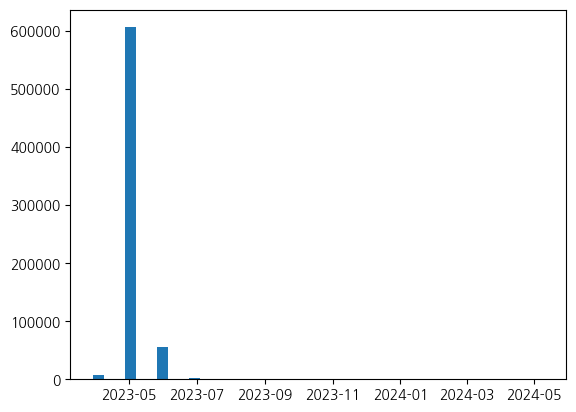

In [58]:
fig, ax = plt.subplots()
ax.hist(merged_df['first_created_at'], width=10, bins=14)
plt.show()

#### 2023ÎÖÑ 3,4Ïõî ÎåÄÎπÑ 5Ïõî Í∞ÄÏûÖÏûê ÎπÑÏú®

In [62]:
year_2023 = merged_df['first_created_at'].dt.year == 2023
month_34 = merged_df['first_created_at'].dt.month <=4
print(f"{round(len(merged_df[year_2023 & month_5]) * 100 / len(merged_df[year_2023 & month_34]),2)}%")

3328.47%


### 2. ÏÑúÎπÑÏä§ ÌôïÏÇ∞ Ìå®ÌÑ¥ ÌôïÏù∏

- 'ÏãúÏûë_ÌïôÍµê': 'Ïñ¥Îäê ÌïôÍµêÏóêÏÑú ÏãúÏûë?‚Äô
- 'ÌôïÏÇ∞_ÏàúÏÑú': 'ÌïôÍµê A ‚Üí B ‚Üí C ÏàúÏÑú‚Äô
- 'ÌôïÏÇ∞_ÏÜçÎèÑ': 'ÌïôÍµêÍ∞Ñ Ï†ÑÌåå ÏÜåÏöî ÏùºÏàò‚Äô
- 'ÏßÄÎ¶¨Ï†Å_Í¥ÄÍ≥Ñ': 'Í∞ÄÍπåÏö¥ ÌïôÍµêÎÅºÎ¶¨ ÌçºÏ°åÎÇò?‚Äô
- ÏÇ¨Ïö©ÏûêÏùò Í∞ÄÏûÖ ÏãúÍ∏∞Î≥Ñ ÌïôÍµê ÏúÑÏπò

#### ÌïôÍµê/ÏπúÍµ¨ ÌååÏùº ÏÑ∏ÌåÖ

In [5]:
accounts_user = pd.read_csv('/home/jovyan/work/data/accounts_user_processed.csv').rename(columns={'id':'user_id'})
accounts_group = pd.read_csv('/home/jovyan/work/data/accounts_group.csv')
accounts_school = pd.read_csv('/home/jovyan/work/data/accounts_school.csv', encoding='UTF-8')
user = pd.merge(merged_df, accounts_user[['user_id','gender','group_id','friend_id_list','friend_count']], on='user_id')
user = pd.merge(user, accounts_group, left_on='group_id', right_on='id')
user = pd.merge(user, accounts_school, left_on='school_id', right_on='id')

In [105]:
user.head(1)

user_id           first_created_at            last_created_at  \
0   833024 2023-03-31 09:05:51.903699 2023-03-31 09:05:51.903699   

    first_created_at_table    last_created_at_table duration gender  group_id  \
0  accounts_user_processed  accounts_user_processed   0 days      F      35.0   

                                      friend_id_list  friend_count  id_x  \
0  [1313154, 1242755, 1435789, 1365775, 1354259, ...            41    35   

   grade  class_num  school_id  id_y  address  student_count school_type  
0      1         10       5464  5464  Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú            158           H

#### ÌïôÍµêÎ≥Ñ ÏµúÏ¥à Í∞ÄÏûÖ ÏãúÏ†ê Î∞è ÏàúÏÑú

In [ ]:
user_df = pd.read_csv("/home/jovyan/work/data/user.csv", parse_dates=["first_created_at"])
school_first_join = user_df.groupby("school_id")["first_created_at"].min().reset_index()
school_first_join = school_first_join.sort_values("first_created_at").reset_index(drop=True)
school_first_join["diffusion_order"] = school_first_join.index + 1

In [ ]:
school_first_join_top20 = school_first_join.sort_values("diffusion_order", ascending=False)[:20]
school_first_join_top20.plot(kind='barh', title='Í∞ÄÏûÖ ÏãúÏ†ê Îπ†Î•∏ ÌïôÍµê top20', figsize=(8, 6))
plt.show()

#### ÌïôÍµê Í∞Ñ ÌôïÏÇ∞ ÏÜçÎèÑ (ÏÜåÏöî ÏùºÏàò)

In [ ]:
school_first_join["diffusion_speed"] = school_first_join["first_created_at"].diff().dt.days.fillna(0).astype(int)

In [ ]:
school_high_diffusion_top20 = school_first_join.sort_values("diffusion_speed", ascending=False)[:20]
school_high_diffusion_top20.plot(kind='barh', title='Ï†ÑÌåå ÏÜçÎèÑ Îπ†Î•∏ ÌïôÍµê top20', figsize=(8, 6))
plt.show()

#### ÏßÄÎ¶¨Ï†Å Ïù∏Ï†ëÏÑ± ÌôïÏù∏

In [ ]:
nearby_df = pd.read_csv("/home/jovyan/work/data/accounts_nearbyschool.csv")

# ÌïôÍµê Í∞Ñ ÌôïÏÇ∞ ÏàúÏÑúÎ•º nearby Í¥ÄÍ≥ÑÏôÄ ÎπÑÍµêÌïòÏó¨ Ïù∏Ï†ë Ï†ÑÌåå Ïó¨Î∂Ä ÌååÏïÖ
school_first_join["former_school"] = school_first_join["school_id"].shift(1)
school_first_join["nearby_diffusion"] = school_first_join.apply(
    lambda row: ((row["former_school"], row["school_id"]) in set(zip(nearby_df["school_id"], nearby_df["nearby_school_id"]))),
    axis=1
)

#### ÏãúÍ∞ÑÎåÄÎ≥Ñ Í∞ÄÏûÖÏûê Í∏âÏ¶ù ÌååÏïÖ

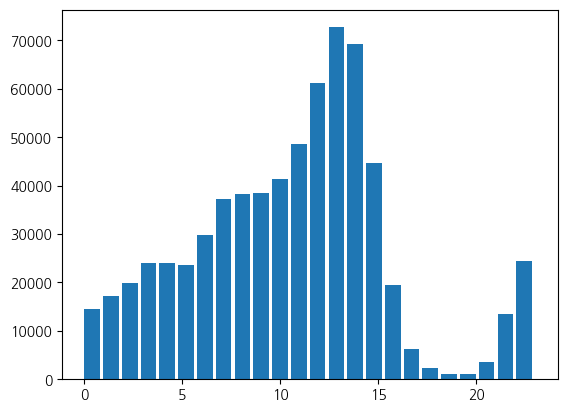

In [50]:
fig, ax = plt.subplots()
ax.hist(merged_df['first_created_at'].dt.hour, width=0.8, bins=24)
plt.show()

ÏµúÍ≥†Ïùò ÌûàÌä∏Îäî Ï†êÏã¨ÏãúÍ∞Ñ

#### Ï¥àÍ∏∞ ÏÇ¨Ïö©Ïûê ÏòÅÌñ•Î†•

In [ ]:
# ÏπúÍµ¨ Ïàò Í∏∞Ï§Ä ÏÉÅÏúÑ Ïú†Ï†Ä ÏÑ†Î≥Ñ (Top 1% or top N)
top_users = user_df.sort_values("friend_count", ascending=False).head(50)

# Ïù¥Îì§Ïùò ÏÜåÏÜç ÌïôÍµê Î∞è Í∞ÄÏûÖ ÏãúÏ†ê Ïù¥ÌõÑ Í∑∏ ÌïôÍµê Í∞ÄÏûÖÎ•† Î≥ÄÌôî Î∂ÑÏÑù
impact_analysis = []

for _, user in top_users.iterrows():
    school_id = user["school_id"]
    join_time = user["first_created_at"]

    # Í∞ôÏùÄ ÌïôÍµê Í∞ÄÏûÖÏûê Ï§ë Ìï¥Îãπ ÏãúÏ†ê Ï†Ñ/ÌõÑ ÎπÑÍµê
    before = user_df[(user_df["school_id"] == school_id) & (user_df["first_created_at"] < join_time)]
    after = user_df[(user_df["school_id"] == school_id) & (user_df["first_created_at"] > join_time)]

    impact_analysis.append({
        "user_id": user["user_id"],
        "school_id": school_id,
        "Í∞ÄÏûÖ_Ïù¥ÌõÑ_Ï¶ùÍ∞Ä": len(after),
        "Í∞ÄÏûÖ_Ïù¥Ï†Ñ": len(before),
        "Ï¶ùÍ∞ÄÏú®": len(after) / (len(before) + 1)
    })

impact_df = pd.DataFrame(impact_analysis)

#### ÌôïÏÇ∞ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù

Ï†ÑÏ≤¥ÏΩîÎìú + ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî

Ï¥ù ÏÇ¨Ïö©Ïûê Ïàò: 676987
Ï¥ù ÌïôÍµê Ïàò: 5550
Ï¥ù ÏßÄÏó≠ Ïàò: 251

=== ÏÑúÎπÑÏä§ ÏãúÏûëÏ†ê Î∂ÑÏÑù ===
Ï¥àÍ∏∞ ÏÇ¨Ïö©Ïûê Í∏∞Ï§Ä ÎÇ†Ïßú: 2023-04-26 08:14:18.848285696
Ï¥àÍ∏∞ ÏÇ¨Ïö©Ïûê Ïàò: 6770

Ï¥àÍ∏∞ ÌôïÏÇ∞ ÌïôÍµê TOP 10:
  ÌïôÍµê ID 2062: 400Î™Ö
  ÌïôÍµê ID 2043: 307Î™Ö
  ÌïôÍµê ID 2079: 298Î™Ö
  ÌïôÍµê ID 2048: 294Î™Ö
  ÌïôÍµê ID 2545: 265Î™Ö
  ÌïôÍµê ID 2078: 225Î™Ö
  ÌïôÍµê ID 2075: 223Î™Ö
  ÌïôÍµê ID 323: 187Î™Ö
  ÌïôÍµê ID 2041: 182Î™Ö
  ÌïôÍµê ID 2071: 152Î™Ö

Ï¥àÍ∏∞ ÌôïÏÇ∞ ÏßÄÏó≠ TOP 10:
  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÜ°ÌååÍµ¨: 3113Î™Ö
  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎèôÍµ¨: 651Î™Ö
  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú: 518Î™Ö
  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨: 489Î™Ö
  Í≤ΩÍ∏∞ÎèÑ ÎÇ®ÏñëÏ£ºÏãú: 286Î™Ö
  Í≤ΩÍ∏∞ÎèÑ ÏÑ±ÎÇ®Ïãú: 232Î™Ö
  Í≤ΩÍ∏∞ÎèÑ ÌïòÎÇ®Ïãú: 165Î™Ö
  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑ±ÎèôÍµ¨: 126Î™Ö
  Ï†ÑÎùºÎÇ®ÎèÑ ÎÇòÏ£ºÏãú: 104Î™Ö
  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÎÖ∏ÏõêÍµ¨: 82Î™Ö

=== ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù ===
ÌïôÍµêÎ≥Ñ ÌôïÏÇ∞ ÏàúÏÑú (Ï≤´ 10Í∞ú):
  5112. ÌïôÍµê ID 5464: 2023-03-31
  284. ÌïôÍµê ID 314: 2023-03-31
  252. ÌïôÍµê ID 281: 202

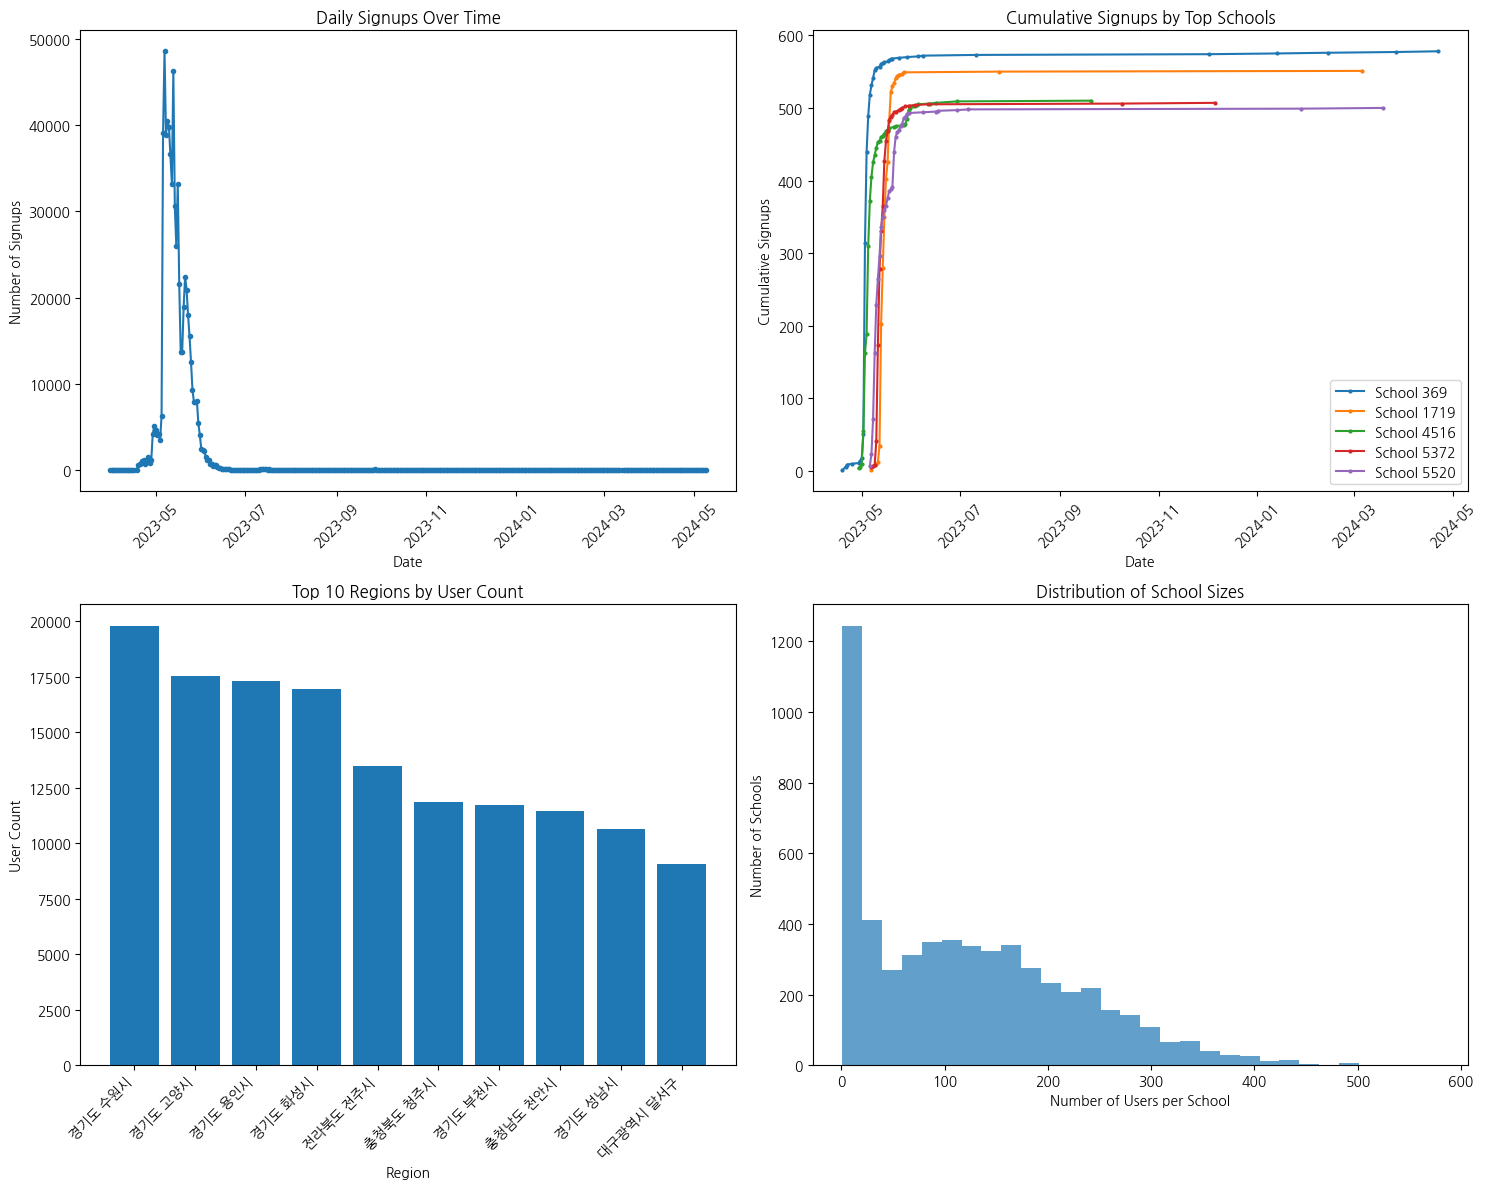

TypeError: draw_networkx_nodes() got an unexpected keyword argument 'font_family'

<Figure size 1200x800 with 0 Axes>

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from collections import defaultdict, Counter
import koreanize_matplotlib

font_path = "/home/jovyan/work/data/nanum-gothic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_prop)
mpl.rcParams['axes.unicode_minus'] = False

class SNSDiffusionAnalyzer:
    def __init__(self, nearby_school_data_path=None):
        """
        SNS ÌôïÏÇ∞ Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî
        
        Args:
            user_data_path: ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú
            nearby_school_data_path: Í∑ºÏ≤ò ÌïôÍµê Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú (ÏÑ†ÌÉùÏÇ¨Ìï≠)
        """
        self.user_df = user
        self.nearby_df = pd.read_csv(nearby_school_data_path) if nearby_school_data_path else None
        
        # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
        self._preprocess_data()
        
        # ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑÎì§
        self.school_network = nx.Graph()
        self.region_network = nx.Graph()
        self.class_network = nx.Graph()
        
    def _preprocess_data(self):
        """Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨"""
        # ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
        self.user_df['first_created_at'] = pd.to_datetime(self.user_df['first_created_at'])
        self.user_df['last_created_at'] = pd.to_datetime(self.user_df['last_created_at'])
        
        # ÏπúÍµ¨ Î¶¨Ïä§Ìä∏ ÌååÏã± (Î¨∏ÏûêÏó¥ÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò)
        self.user_df['friend_id_list'] = self.user_df['friend_id_list'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else []
        )
        
        # ÏßÄÏó≠ Ï†ïÎ≥¥ Ï∂îÏ∂ú (Ïãú/Íµ∞/Íµ¨ÍπåÏßÄ)
        self.user_df['region'] = self.user_df['address'].apply(
            lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
        )
        
        # ÌïôÍµê-ÌïôÍ∏â Ï°∞Ìï© ÏÉùÏÑ±
        self.user_df['school_class'] = self.user_df['school_id'].astype(str) + '_' + \
                                      self.user_df['grade'].astype(str) + '_' + \
                                      self.user_df['class_num'].astype(str)
        
        print(f"Ï¥ù ÏÇ¨Ïö©Ïûê Ïàò: {len(self.user_df)}")
        print(f"Ï¥ù ÌïôÍµê Ïàò: {self.user_df['school_id'].nunique()}")
        print(f"Ï¥ù ÏßÄÏó≠ Ïàò: {self.user_df['region'].nunique()}")
        
    def analyze_diffusion_start(self):
        """ÏÑúÎπÑÏä§ ÏãúÏûëÏ†ê Î∂ÑÏÑù"""
        print("\n=== ÏÑúÎπÑÏä§ ÏãúÏûëÏ†ê Î∂ÑÏÑù ===")
        
        # Í∞ÄÏû• Î®ºÏ†Ä Í∞ÄÏûÖÌïú ÏÇ¨Ïö©ÏûêÎì§ (ÏÉÅÏúÑ 1%)
        early_threshold = self.user_df['first_created_at'].quantile(0.01)
        early_users = self.user_df[self.user_df['first_created_at'] <= early_threshold]
        
        print(f"Ï¥àÍ∏∞ ÏÇ¨Ïö©Ïûê Í∏∞Ï§Ä ÎÇ†Ïßú: {early_threshold}")
        print(f"Ï¥àÍ∏∞ ÏÇ¨Ïö©Ïûê Ïàò: {len(early_users)}")
        
        # Ï¥àÍ∏∞ ÏÇ¨Ïö©ÏûêÎì§Ïùò ÌïôÍµê/ÏßÄÏó≠ Î∂ÑÌè¨
        start_schools = early_users['school_id'].value_counts().head(10)
        start_regions = early_users['region'].value_counts().head(10)
        
        print("\nÏ¥àÍ∏∞ ÌôïÏÇ∞ ÌïôÍµê TOP 10:")
        for school_id, count in start_schools.items():
            print(f"  ÌïôÍµê ID {school_id}: {count}Î™Ö")
            
        print("\nÏ¥àÍ∏∞ ÌôïÏÇ∞ ÏßÄÏó≠ TOP 10:")
        for region, count in start_regions.items():
            print(f"  {region}: {count}Î™Ö")
            
        return early_users, start_schools, start_regions
    
    def analyze_diffusion_order(self):
        """ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù"""
        print("\n=== ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù ===")
        
        # ÌïôÍµêÎ≥Ñ Ï≤´ ÏÇ¨Ïö©Ïûê Í∞ÄÏûÖ ÏãúÏ†ê
        school_first_user = self.user_df.groupby('school_id')['first_created_at'].min().reset_index()
        school_first_user = school_first_user.sort_values('first_created_at')
        
        # ÏßÄÏó≠Î≥Ñ Ï≤´ ÏÇ¨Ïö©Ïûê Í∞ÄÏûÖ ÏãúÏ†ê
        region_first_user = self.user_df.groupby('region')['first_created_at'].min().reset_index()
        region_first_user = region_first_user.sort_values('first_created_at')
        
        print("ÌïôÍµêÎ≥Ñ ÌôïÏÇ∞ ÏàúÏÑú (Ï≤´ 10Í∞ú):")
        for i, row in school_first_user.head(10).iterrows():
            print(f"  {i+1}. ÌïôÍµê ID {row['school_id']}: {row['first_created_at'].strftime('%Y-%m-%d')}")
            
        print("\nÏßÄÏó≠Î≥Ñ ÌôïÏÇ∞ ÏàúÏÑú (Ï≤´ 10Í∞ú):")
        for i, row in region_first_user.head(10).iterrows():
            print(f"  {i+1}. {row['region']}: {row['first_created_at'].strftime('%Y-%m-%d')}")
            
        return school_first_user, region_first_user
    
    def analyze_diffusion_speed(self):
        """ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù"""
        print("\n=== ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù ===")
        
        # ÌïôÍµêÎ≥Ñ Ï≤´ ÏÇ¨Ïö©ÏûêÏôÄ 100Î≤àÏß∏ ÏÇ¨Ïö©Ïûê Í∞ÑÏùò ÏãúÍ∞ÑÏ∞®
        school_speeds = []
        
        for school_id in self.user_df['school_id'].unique():
            school_users = self.user_df[self.user_df['school_id'] == school_id].sort_values('first_created_at')
            
            if len(school_users) >= 10:  # ÏµúÏÜå 10Î™Ö Ïù¥ÏÉÅÏù∏ ÌïôÍµêÎßå
                first_user_date = school_users.iloc[0]['first_created_at']
                tenth_user_date = school_users.iloc[9]['first_created_at']  # 10Î≤àÏß∏ ÏÇ¨Ïö©Ïûê
                
                speed_days = (tenth_user_date - first_user_date).days
                
                school_speeds.append({
                    'school_id': school_id,
                    'first_date': first_user_date,
                    'tenth_date': tenth_user_date,
                    'speed_days': speed_days,
                    'total_users': len(school_users)
                })
        
        speed_df = pd.DataFrame(school_speeds)
        speed_df = speed_df.sort_values('speed_days')
        
        print("ÌïôÍµêÎÇ¥ ÌôïÏÇ∞ ÏÜçÎèÑ TOP 10 (Îπ†Î•∏ Ïàú):")
        for _, row in speed_df.head(10).iterrows():
            print(f"  ÌïôÍµê ID {row['school_id']}: {row['speed_days']}Ïùº "
                  f"(Ï¥ù {row['total_users']}Î™Ö)")
            
        return speed_df
    
    def build_region_network(self):
        """ÏßÄÏó≠ Í∞Ñ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï"""
        print("\n=== ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï ===")
        
        # ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Îß§Ìïë
        region_users = defaultdict(list)
        for _, user in self.user_df.iterrows():
            region_users[user['region']].append(user['user_id'])
        
        # ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ Ïπ¥Ïö¥Ìä∏
        region_connections = defaultdict(int)
        
        for _, user in self.user_df.iterrows():
            user_region = user['region']
            friends = user['friend_id_list']
            
            for friend_id in friends:
                friend_info = self.user_df[self.user_df['user_id'] == friend_id]
                if not friend_info.empty:
                    friend_region = friend_info.iloc[0]['region']
                    if user_region != friend_region:
                        region_pair = tuple(sorted([user_region, friend_region]))
                        region_connections[region_pair] += 1
        
        # ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ Íµ¨Ï∂ï
        for (region1, region2), weight in region_connections.items():
            if weight >= 5:  # ÏµúÏÜå 5Í∞ú Ïù¥ÏÉÅÏùò ÏπúÍµ¨ Í¥ÄÍ≥Ñ
                self.region_network.add_edge(region1, region2, weight=weight)
        
        print(f"ÏßÄÏó≠ ÎÖ∏Îìú Ïàò: {self.region_network.number_of_nodes()}")
        print(f"ÏßÄÏó≠ Í∞Ñ Ïó∞Í≤∞ Ïàò: {self.region_network.number_of_edges()}")
        
        return region_connections
    
    def build_school_network(self):
        """ÌïôÍµê Í∞Ñ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï"""
        print("\n=== ÌïôÍµê ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï ===")
        
        # ÌïôÍµêÎ≥Ñ ÏÇ¨Ïö©Ïûê Îß§Ìïë
        school_users = defaultdict(list)
        for _, user in self.user_df.iterrows():
            school_users[user['school_id']].append(user['user_id'])
        
        # ÌïôÍµê Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ Ïπ¥Ïö¥Ìä∏
        school_connections = defaultdict(int)
        
        for _, user in self.user_df.iterrows():
            user_school = user['school_id']
            friends = user['friend_id_list']
            
            for friend_id in friends:
                friend_info = self.user_df[self.user_df['user_id'] == friend_id]
                if not friend_info.empty:
                    friend_school = friend_info.iloc[0]['school_id']
                    if user_school != friend_school:
                        school_pair = tuple(sorted([user_school, friend_school]))
                        school_connections[school_pair] += 1
        
        # ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ Íµ¨Ï∂ï
        for (school1, school2), weight in school_connections.items():
            if weight >= 3:  # ÏµúÏÜå 3Í∞ú Ïù¥ÏÉÅÏùò ÏπúÍµ¨ Í¥ÄÍ≥Ñ
                self.school_network.add_edge(school1, school2, weight=weight)
        
        print(f"ÌïôÍµê ÎÖ∏Îìú Ïàò: {self.school_network.number_of_nodes()}")
        print(f"ÌïôÍµê Í∞Ñ Ïó∞Í≤∞ Ïàò: {self.school_network.number_of_edges()}")
        
        return school_connections
    
    def analyze_geographic_relationship(self):
        """ÏßÄÎ¶¨Ï†Å Í¥ÄÍ≥Ñ Î∂ÑÏÑù"""
        if self.nearby_df is None:
            print("Í∑ºÏ≤ò ÌïôÍµê Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏßÄÎ¶¨Ï†Å Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
            return None
            
        print("\n=== ÏßÄÎ¶¨Ï†Å Í¥ÄÍ≥Ñ Î∂ÑÏÑù ===")
        
        # Í∑ºÏ≤ò ÌïôÍµê Í∞Ñ Ïã§Ï†ú ÏπúÍµ¨ Í¥ÄÍ≥Ñ ÌôïÏù∏
        nearby_connections = 0
        total_connections = 0
        
        geographic_analysis = []
        
        for edge in self.school_network.edges(data=True):
            school1, school2, data = edge
            weight = data['weight']
            total_connections += weight
            
            # Îëê ÌïôÍµêÍ∞Ä 50km Ïù¥ÎÇ¥Ïù∏ÏßÄ ÌôïÏù∏
            is_nearby = False
            nearby_info = self.nearby_df[
                ((self.nearby_df['school_id'] == school1) & 
                 (self.nearby_df['nearby_school_id'] == school2)) |
                ((self.nearby_df['school_id'] == school2) & 
                 (self.nearby_df['nearby_school_id'] == school1))
            ]
            
            if not nearby_info.empty:
                is_nearby = True
                distance = nearby_info.iloc[0]['distance']
                nearby_connections += weight
            else:
                distance = None
            
            geographic_analysis.append({
                'school1': school1,
                'school2': school2,
                'connections': weight,
                'is_nearby': is_nearby,
                'distance': distance
            })
        
        geo_df = pd.DataFrame(geographic_analysis)
        
        nearby_ratio = nearby_connections / total_connections if total_connections > 0 else 0
        
        print(f"Ï¥ù ÌïôÍµê Í∞Ñ Ïó∞Í≤∞: {total_connections}")
        print(f"Í∑ºÍ±∞Î¶¨ ÌïôÍµê Í∞Ñ Ïó∞Í≤∞: {nearby_connections}")
        print(f"Í∑ºÍ±∞Î¶¨ Ïó∞Í≤∞ ÎπÑÏú®: {nearby_ratio:.2%}")
        
        return geo_df
    
    def visualize_region_network(self, top_n=15):
        """ÏÉÅÏúÑ NÍ∞ú ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî"""
        print(f"\n=== ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî ===")
        
        # ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò Í≥ÑÏÇ∞
        region_counts = self.user_df['region'].value_counts()
        top_regions = region_counts.head(top_n).index.tolist()
        
        print(f"Î∂ÑÏÑù ÎåÄÏÉÅ ÏßÄÏó≠: {', '.join(top_regions)}")
        
        # ÏÉÅÏúÑ ÏßÄÏó≠Îßå Ìè¨Ìï®ÌïòÎäî ÏÑúÎ∏åÍ∑∏ÎûòÌîÑ ÏÉùÏÑ±
        region_subgraph = nx.Graph()
        
        # ÏÉÅÏúÑ ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ Ïπ¥Ïö¥Ìä∏
        region_connections = defaultdict(int)
        
        for _, user in self.user_df.iterrows():
            user_region = user['region']
            if user_region not in top_regions:
                continue
                
            friends = user['friend_id_list']
            
            for friend_id in friends:
                friend_info = self.user_df[self.user_df['user_id'] == friend_id]
                if not friend_info.empty:
                    friend_region = friend_info.iloc[0]['region']
                    if friend_region in top_regions and user_region != friend_region:
                        region_pair = tuple(sorted([user_region, friend_region]))
                        region_connections[region_pair] += 1
        
        # ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï (ÏµúÏÜå Ïó∞Í≤∞ ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï)
        min_connections = 3
        for (region1, region2), weight in region_connections.items():
            if weight >= min_connections:
                region_subgraph.add_edge(region1, region2, weight=weight)
        
        # Ïó∞Í≤∞ÎêòÏßÄ ÏïäÏùÄ ÏÉÅÏúÑ ÏßÄÏó≠Îì§ÎèÑ ÎÖ∏ÎìúÎ°ú Ï∂îÍ∞Ä
        for region in top_regions:
            if region not in region_subgraph.nodes():
                region_subgraph.add_node(region)
        
        # ÏãúÍ∞ÅÌôî
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # 1. ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ
        if region_subgraph.number_of_nodes() > 0:
            # Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï
            pos = nx.spring_layout(region_subgraph, k=3, iterations=50, seed=42)
            
            # ÎÖ∏Îìú ÌÅ¨Í∏∞: ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê ÏàòÏóê ÎπÑÎ°Ä
            node_sizes = []
            node_colors = []
            for node in region_subgraph.nodes():
                user_count = region_counts.get(node, 0)
                node_sizes.append(user_count * 2)  # ÌÅ¨Í∏∞ Ï°∞Ï†ï
                # ÏÇ¨Ïö©Ïûê ÏàòÏóê Îî∞Î•∏ ÏÉâÏÉÅ Í∑∏ÎùºÎç∞Ïù¥ÏÖò
                node_colors.append(user_count)
            
            # Ïó£ÏßÄ ÎëêÍªò: Ïó∞Í≤∞ Í∞ïÎèÑÏóê ÎπÑÎ°Ä
            edge_widths = []
            edge_colors = []
            for u, v in region_subgraph.edges():
                if region_subgraph.has_edge(u, v):
                    weight = region_subgraph[u][v]['weight']
                    edge_widths.append(weight * 0.1)
                    edge_colors.append(weight)
                else:
                    edge_widths.append(1)
                    edge_colors.append(1)
            
            # ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏Î¶¨Í∏∞
            nodes = nx.draw_networkx_nodes(
                region_subgraph, pos, 
                node_size=node_sizes, 
                node_color=node_colors,
                cmap='YlOrRd',
                alpha=0.8,
                ax=ax1
            )
            
            if region_subgraph.number_of_edges() > 0:
                edges = nx.draw_networkx_edges(
                    region_subgraph, pos, 
                    width=edge_widths, 
                    edge_color=edge_colors,
                    edge_cmap='Blues',
                    alpha=0.6,
                    ax=ax1
                )
            
            # ÎùºÎ≤® Í∑∏Î¶¨Í∏∞ (ÏßÄÏó≠Î™Ö)
            nx.draw_networkx_labels(
                region_subgraph, pos, 
                font_size=10, 
                font_weight='bold',
                font_family=font_prop,
                ax=ax1
            )
            
            ax1.set_title(f'ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ ÎÑ§Ìä∏ÏõåÌÅ¨\n(ÎÖ∏Îìú ÌÅ¨Í∏∞: ÏÇ¨Ïö©Ïûê Ïàò, Ïó£ÏßÄ ÎëêÍªò: ÏπúÍµ¨ Í¥ÄÍ≥Ñ Ïàò)', fontsize=14, pad=20)
            ax1.axis('off')
            
            # Ïª¨Îü¨Î∞î Ï∂îÍ∞Ä
            if len(node_colors) > 0:
                plt.colorbar(nodes, ax=ax1, label='ÏÇ¨Ïö©Ïûê Ïàò', shrink=0.8)
        
        # 2. ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò ÎßâÎåÄ Í∑∏ÎûòÌîÑ
        top_region_counts = region_counts.head(top_n)
        bars = ax2.bar(range(len(top_region_counts)), top_region_counts.values, 
                      color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1)
        
        ax2.set_title(f'ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò', fontsize=14, pad=20)
        ax2.set_xlabel('ÏßÄÏó≠', fontsize=12)
        ax2.set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
        ax2.set_xticks(range(len(top_region_counts)))
        ax2.set_xticklabels(top_region_counts.index, rotation=45, ha='right')
        
        # ÎßâÎåÄ ÏúÑÏóê ÏàòÏπò ÌëúÏãú
        for i, (bar, value) in enumerate(zip(bars, top_region_counts.values)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
        
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Ïó∞Í≤∞ ÌÜµÍ≥Ñ Ï∂úÎ†•
        print(f"\nüìä ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÌÜµÍ≥Ñ:")
        print(f"  ‚Ä¢ Ï†ÑÏ≤¥ ÏßÄÏó≠ Ïàò: {len(top_regions)}")
        print(f"  ‚Ä¢ Ïó∞Í≤∞Îêú ÏßÄÏó≠ Ïàò: {region_subgraph.number_of_nodes()}")
        print(f"  ‚Ä¢ ÏßÄÏó≠ Í∞Ñ Ïó∞Í≤∞ Ïàò: {region_subgraph.number_of_edges()}")
        
        if region_connections:
            print(f"\nüîó Ï£ºÏöî ÏßÄÏó≠ Í∞Ñ Ïó∞Í≤∞ (ÏÉÅÏúÑ 10Í∞ú):")
            sorted_connections = sorted(region_connections.items(), key=lambda x: x[1], reverse=True)
            for i, ((region1, region2), count) in enumerate(sorted_connections[:10]):
                print(f"  {i+1:2d}. {region1} ‚Üî {region2}: {count:,}Í∞ú ÏπúÍµ¨ Í¥ÄÍ≥Ñ")
        
        return region_subgraph, region_connections
    
    def visualize_diffusion_timeline(self):
        """ÌôïÏÇ∞ ÌÉÄÏûÑÎùºÏù∏ ÏãúÍ∞ÅÌôî"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. ÏùºÎ≥Ñ Í∞ÄÏûÖÏûê Ïàò
        daily_signups = self.user_df.groupby(self.user_df['first_created_at'].dt.date).size()
        axes[0,0].plot(daily_signups.index, daily_signups.values, marker='o', markersize=3)
        axes[0,0].set_title('Daily Signups Over Time')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel('Number of Signups')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # 2. ÌïôÍµêÎ≥Ñ ÎàÑÏ†Å Í∞ÄÏûÖÏûê
        top_schools = self.user_df['school_id'].value_counts().head(5)
        for school_id in top_schools.index:
            school_data = self.user_df[self.user_df['school_id'] == school_id]
            daily_school = school_data.groupby(school_data['first_created_at'].dt.date).size().cumsum()
            axes[0,1].plot(daily_school.index, daily_school.values, label=f'School {school_id}', marker='o', markersize=2)
        
        axes[0,1].set_title('Cumulative Signups by Top Schools')
        axes[0,1].set_xlabel('Date')
        axes[0,1].set_ylabel('Cumulative Signups')
        axes[0,1].legend()
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # 3. ÏßÄÏó≠Î≥Ñ Í∞ÄÏûÖÏûê Î∂ÑÌè¨
        region_counts = self.user_df['region'].value_counts().head(10)
        axes[1,0].bar(range(len(region_counts)), region_counts.values)
        axes[1,0].set_title('Top 10 Regions by User Count')
        axes[1,0].set_xlabel('Region')
        axes[1,0].set_ylabel('User Count')
        axes[1,0].set_xticks(range(len(region_counts)))
        axes[1,0].set_xticklabels(region_counts.index, rotation=45, ha='right')
        
        # 4. ÌïôÍµê Í∑úÊ®°Î≥Ñ Î∂ÑÌè¨
        school_sizes = self.user_df.groupby('school_id').size()
        axes[1,1].hist(school_sizes.values, bins=30, alpha=0.7)
        axes[1,1].set_title('Distribution of School Sizes')
        axes[1,1].set_xlabel('Number of Users per School')
        axes[1,1].set_ylabel('Number of Schools')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_network(self, network_type='school', top_n=20):
        """ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî"""
        if network_type == 'school' and self.school_network.number_of_nodes() > 0:
            G = self.school_network
            title = 'ÌïôÍµê ÎÑ§Ìä∏ÏõåÌÅ¨'
        elif network_type == 'region' and self.region_network.number_of_nodes() > 0:
            G = self.region_network
            title = 'ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨'
        else:
            print(f"{network_type} ÎÑ§Ìä∏ÏõåÌÅ¨Í∞Ä Íµ¨Ï∂ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
            return
        
        # Í∞ÄÏû• Ïó∞Í≤∞Ïù¥ ÎßéÏùÄ ÏÉÅÏúÑ NÍ∞ú ÎÖ∏ÎìúÎßå ÏãúÍ∞ÅÌôî
        degrees = dict(G.degree())
        top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:top_n]
        G_sub = G.subgraph(top_nodes)
        
        plt.figure(figsize=(12, 8))
        
        # Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï
        pos = nx.spring_layout(G_sub, k=1, iterations=50)
        
        # ÎÖ∏Îìú ÌÅ¨Í∏∞ ÏÑ§Ï†ï
        node_sizes = []
        for node in G_sub.nodes():
            if network_type == 'school':
                user_count = len(self.user_df[self.user_df['school_id'] == node])
                node_sizes.append(user_count * 10)
            else:  # region
                user_count = len(self.user_df[self.user_df['region'] == node])
                node_sizes.append(user_count * 2)
        
        # Ïó£ÏßÄ ÎëêÍªò: Ïó∞Í≤∞ Í∞ïÎèÑÏóê ÎπÑÎ°Ä
        edge_widths = []
        for u, v in G_sub.edges():
            weight = G_sub[u][v]['weight']
            edge_widths.append(weight * 0.5)
        
        # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
        nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, alpha=0.7, node_color='lightblue')
        nx.draw_networkx_edges(G_sub, pos, width=edge_widths, alpha=0.5, edge_color='gray')
        nx.draw_networkx_labels(G_sub, pos, font_size=8, font_family=font_prop)
        
        plt.title(f'{title} (ÏÉÅÏúÑ {top_n}Í∞ú Ïó∞Í≤∞Îêú ÎÖ∏Îìú)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """Ï¢ÖÌï© Î∂ÑÏÑù Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""
        print("\n" + "="*50)
        print("SNS ÏÑúÎπÑÏä§ ÌôïÏÇ∞ Ìå®ÌÑ¥ Î∂ÑÏÑù Ï¢ÖÌï© Î≥¥Í≥†ÏÑú")
        print("="*50)
        
        # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
        total_users = len(self.user_df)
        total_schools = self.user_df['school_id'].nunique()
        total_regions = self.user_df['region'].nunique()
        
        print(f"\nüìä Í∏∞Î≥∏ ÌÜµÍ≥Ñ:")
        print(f"  ‚Ä¢ Ï¥ù ÏÇ¨Ïö©Ïûê Ïàò: {total_users:,}Î™Ö")
        print(f"  ‚Ä¢ Ï¥ù ÌïôÍµê Ïàò: {total_schools:,}Í∞ú")
        print(f"  ‚Ä¢ Ï¥ù ÏßÄÏó≠ Ïàò: {total_regions:,}Í∞ú")
        
        # ÏãúÍ∞Ñ Î≤îÏúÑ
        start_date = self.user_df['first_created_at'].min()
        end_date = self.user_df['first_created_at'].max()
        duration = (end_date - start_date).days
        
        print(f"\nüìÖ ÏÑúÎπÑÏä§ ÌôïÏÇ∞ Í∏∞Í∞Ñ:")
        print(f"  ‚Ä¢ ÏãúÏûëÏùº: {start_date.strftime('%Y-%m-%d')}")
        print(f"  ‚Ä¢ Ï¢ÖÎ£åÏùº: {end_date.strftime('%Y-%m-%d')}")
        print(f"  ‚Ä¢ Ï¥ù Í∏∞Í∞Ñ: {duration}Ïùº")
        
        # ÎÑ§Ìä∏ÏõåÌÅ¨ ÌÜµÍ≥Ñ
        if self.school_network.number_of_nodes() > 0:
            print(f"\nüåê ÌïôÍµê ÎÑ§Ìä∏ÏõåÌÅ¨ ÌÜµÍ≥Ñ:")
            print(f"  ‚Ä¢ Ïó∞Í≤∞Îêú ÌïôÍµê Ïàò: {self.school_network.number_of_nodes()}")
            print(f"  ‚Ä¢ ÌïôÍµê Í∞Ñ Ïó∞Í≤∞ Ïàò: {self.school_network.number_of_edges()}")
            
            if self.school_network.number_of_nodes() > 1:
                avg_degree = sum(dict(self.school_network.degree()).values()) / self.school_network.number_of_nodes()
                print(f"  ‚Ä¢ ÌèâÍ∑† Ïó∞Í≤∞ÎèÑ: {avg_degree:.2f}")

# ÏÇ¨Ïö© ÏòàÏãú
def main():
    """Î©îÏù∏ Ïã§Ìñâ Ìï®Ïàò"""
    
    # Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî (ÌååÏùº Í≤ΩÎ°úÎäî Ïã§Ï†ú Í≤ΩÎ°úÎ°ú Î≥ÄÍ≤Ω ÌïÑÏöî)
    analyzer = SNSDiffusionAnalyzer(
        nearby_school_data_path='/home/jovyan/work/data/accounts_nearbyschool.csv'
    )
    
    # 1. ÏÑúÎπÑÏä§ ÏãúÏûëÏ†ê Î∂ÑÏÑù
    early_users, start_schools, start_regions = analyzer.analyze_diffusion_start()
    
    # 2. ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù
    school_order, region_order = analyzer.analyze_diffusion_order()
    
    # 3. ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù
    speed_analysis = analyzer.analyze_diffusion_speed()
    
    # 4. ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï
    school_connections = analyzer.build_school_network()
    region_connections = analyzer.build_region_network()
    
    # 5. ÏßÄÎ¶¨Ï†Å Í¥ÄÍ≥Ñ Î∂ÑÏÑù
    geo_analysis = analyzer.analyze_geographic_relationship()
    
    # 6. ÏãúÍ∞ÅÌôî
    analyzer.visualize_diffusion_timeline()
    analyzer.visualize_network('school', top_n=15)
    
    # 7. ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî
    analyzer.visualize_region_network(top_n=15)
    
    # 8. Ï¢ÖÌï© Î≥¥Í≥†ÏÑú
    analyzer.generate_summary_report()
    
    return analyzer

if __name__ == "__main__":
    # Ïã§Ìñâ
    analyzer = main()

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from collections import defaultdict, Counter
import koreanize_matplotlib
import pickle
import scipy

font_path = "/home/jovyan/work/data/nanum-gothic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_prop)
mpl.rcParams['axes.unicode_minus'] = False

class SNSDiffusionAnalyzer:
    def __init__(self, user_df: pd.DataFrame, nearby_school_data_path=None):
        self.user_df = user_df.copy()
        self.user_df.set_index('user_id', inplace=True)  # üî• ÌïµÏã¨ ÏµúÏ†ÅÌôî

        self.nearby_df = pd.read_csv(nearby_school_data_path) if nearby_school_data_path else None
        self._preprocess_data()

        self.school_network = nx.Graph()
        self.region_network = nx.Graph()

    def _preprocess_data(self):
        self.user_df['first_created_at'] = pd.to_datetime(self.user_df['first_created_at'])
        self.user_df['last_created_at'] = pd.to_datetime(self.user_df['last_created_at'])

        self.user_df['friend_id_list'] = self.user_df['friend_id_list'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else []
        )
        self.user_df['region'] = self.user_df['address'].apply(
            lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
        )

    def build_region_network(self, save_path=None):
        region_connections = {}

        for user_id, user in self.user_df.iterrows():
            user_region = user['region']
            for friend_id in user['friend_id_list']:
                if friend_id in self.user_df.index:
                    friend_region = self.user_df.loc[friend_id, 'region']
                    if user_region != friend_region:
                        pair = tuple(sorted([user_region, friend_region]))
                        region_connections[pair] = region_connections.get(pair, 0) + 1

        for (region1, region2), weight in region_connections.items():
            if weight >= 5:
                self.region_network.add_edge(region1, region2, weight=weight)

        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump(self.region_network, f)

        print(f"[ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨] ÎÖ∏Îìú Ïàò: {self.region_network.number_of_nodes()}, Ïó£ÏßÄ Ïàò: {self.region_network.number_of_edges()}")
        return self.region_network

    def build_school_network(self, save_path=None):
        school_connections = {}

        for user_id, user in self.user_df.iterrows():
            user_school = user['school_id']
            for friend_id in user['friend_id_list']:
                if friend_id in self.user_df.index:
                    friend_school = self.user_df.loc[friend_id, 'school_id']
                    if user_school != friend_school:
                        pair = tuple(sorted([user_school, friend_school]))
                        school_connections[pair] = school_connections.get(pair, 0) + 1

        for (school1, school2), weight in school_connections.items():
            if weight >= 3:
                self.school_network.add_edge(school1, school2, weight=weight)

        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump(self.school_network, f)

        print(f"[ÌïôÍµê ÎÑ§Ìä∏ÏõåÌÅ¨] ÎÖ∏Îìú Ïàò: {self.school_network.number_of_nodes()}, Ïó£ÏßÄ Ïàò: {self.school_network.number_of_edges()}")
        return self.school_network

    def visualize_network(self, network: nx.Graph, title="Network", layout='spring', node_size=50, save_path=None):
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(network, seed=42) if layout == 'spring' else nx.kamada_kawai_layout(network)

        weights = [d['weight'] for _, _, d in network.edges(data=True)]
        nx.draw(network, pos, with_labels=True, node_size=node_size, width=[w * 0.1 for w in weights],
                edge_color='gray', node_color='skyblue', font_size=8, font_family=font_prop)

        plt.title(title)
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

[ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨] ÎÖ∏Îìú Ïàò: 249, Ïó£ÏßÄ Ïàò: 15851
[ÌïôÍµê ÎÑ§Ìä∏ÏõåÌÅ¨] ÎÖ∏Îìú Ïàò: 5347, Ïó£ÏßÄ Ïàò: 197060


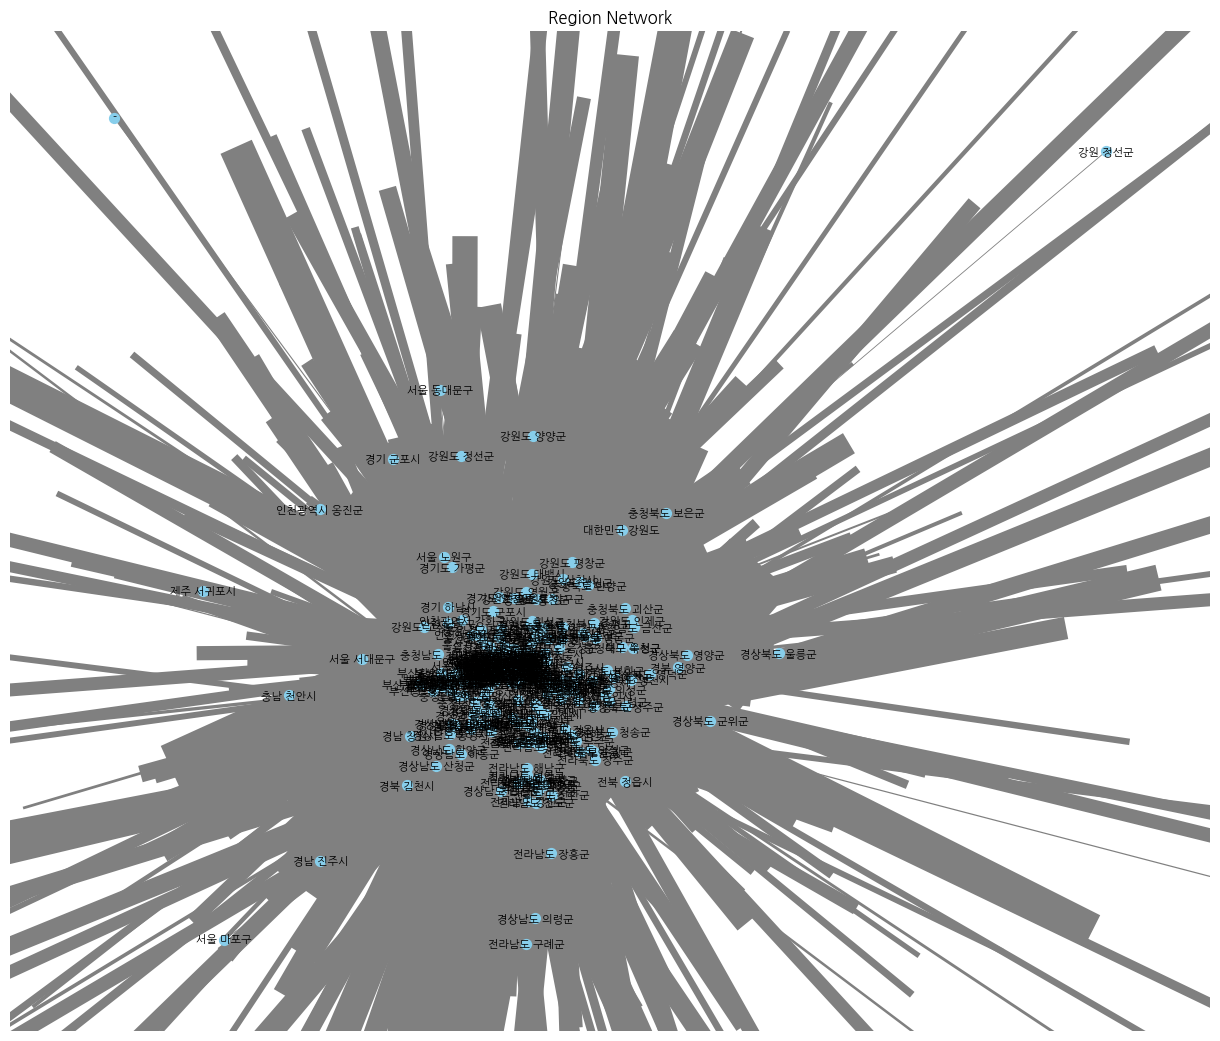

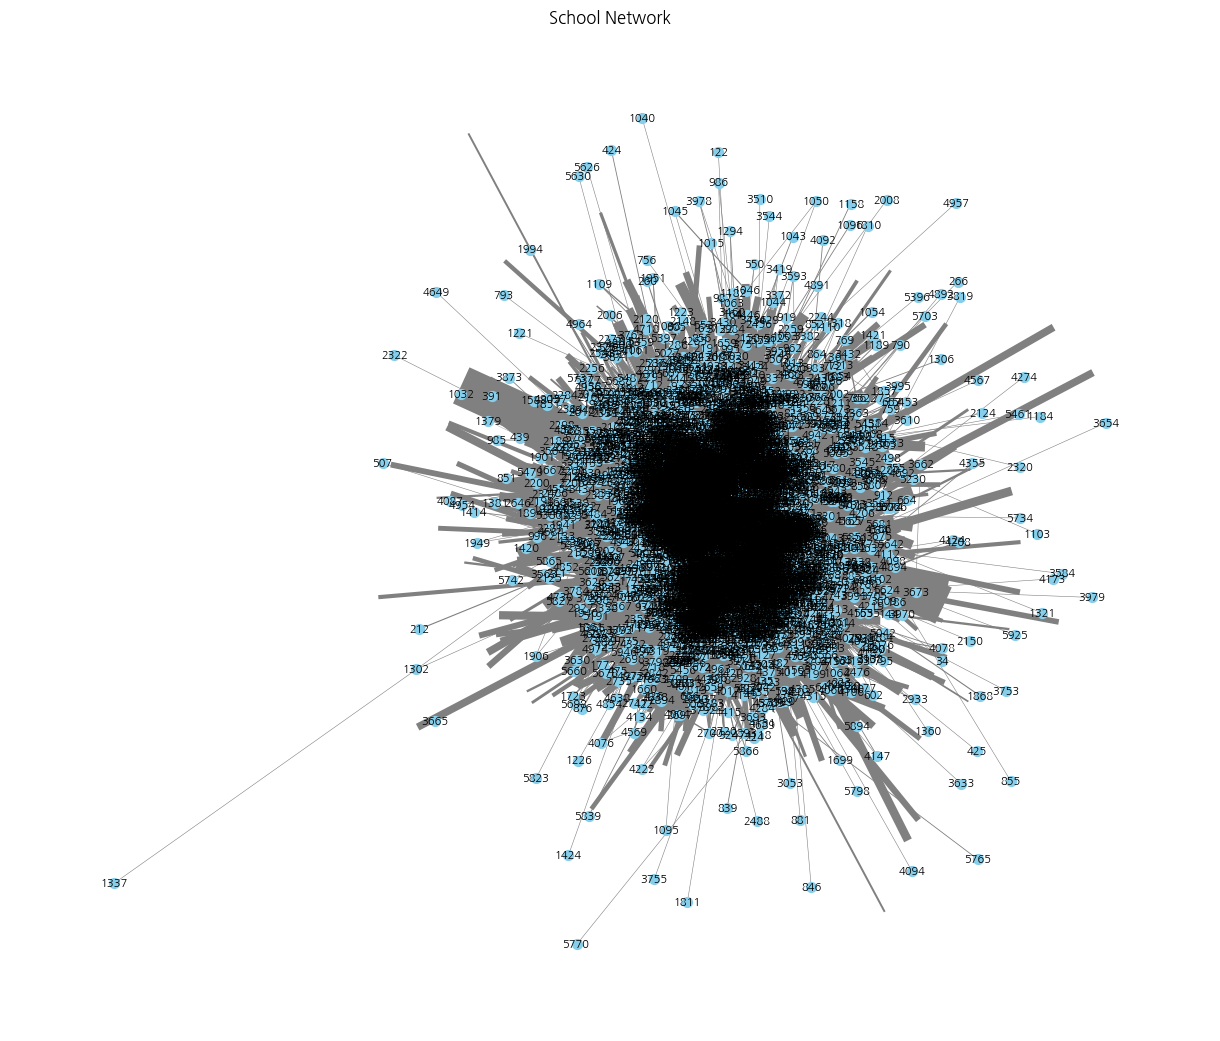

In [9]:
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ userÎ•º ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©
analyzer = SNSDiffusionAnalyzer(user)

# ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï Î∞è Ï†ÄÏû•
region_net = analyzer.build_region_network('region_network.pkl')
school_net = analyzer.build_school_network('school_network.pkl')

# ÏãúÍ∞ÅÌôî
analyzer.visualize_network(region_net, title="Region Network", save_path="region_network.png")
analyzer.visualize_network(school_net, title="School Network", save_path="school_network.png")

ÏßÄÏó≠Í∞Ñ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî

üöÄ ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî ÏãúÏûë!
üìä Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
üîÑ ÏπúÍµ¨ Î¶¨Ïä§Ìä∏ ÌååÏã± Ï§ë...
üìç Ï¥ù ÏßÄÏó≠ Ïàò: 251
‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎî© ÏôÑÎ£å - Ï¥ù 676,987Î™Ö ÏÇ¨Ïö©Ïûê

üåê ÏÉÅÏúÑ 15Í∞ú ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï Ï§ë...
üìç Î∂ÑÏÑù ÎåÄÏÉÅ ÏßÄÏó≠: Í≤ΩÍ∏∞ÎèÑ ÏàòÏõêÏãú, Í≤ΩÍ∏∞ÎèÑ Í≥†ÏñëÏãú, Í≤ΩÍ∏∞ÎèÑ Ïö©Ïù∏Ïãú, Í≤ΩÍ∏∞ÎèÑ ÌôîÏÑ±Ïãú, Ï†ÑÎùºÎ∂ÅÎèÑ Ï†ÑÏ£ºÏãú...
üîó ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ Î∂ÑÏÑù Ï§ë...
‚úÖ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï ÏôÑÎ£å - ÎÖ∏Îìú: 15, Ïó£ÏßÄ: 0
üé® ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...


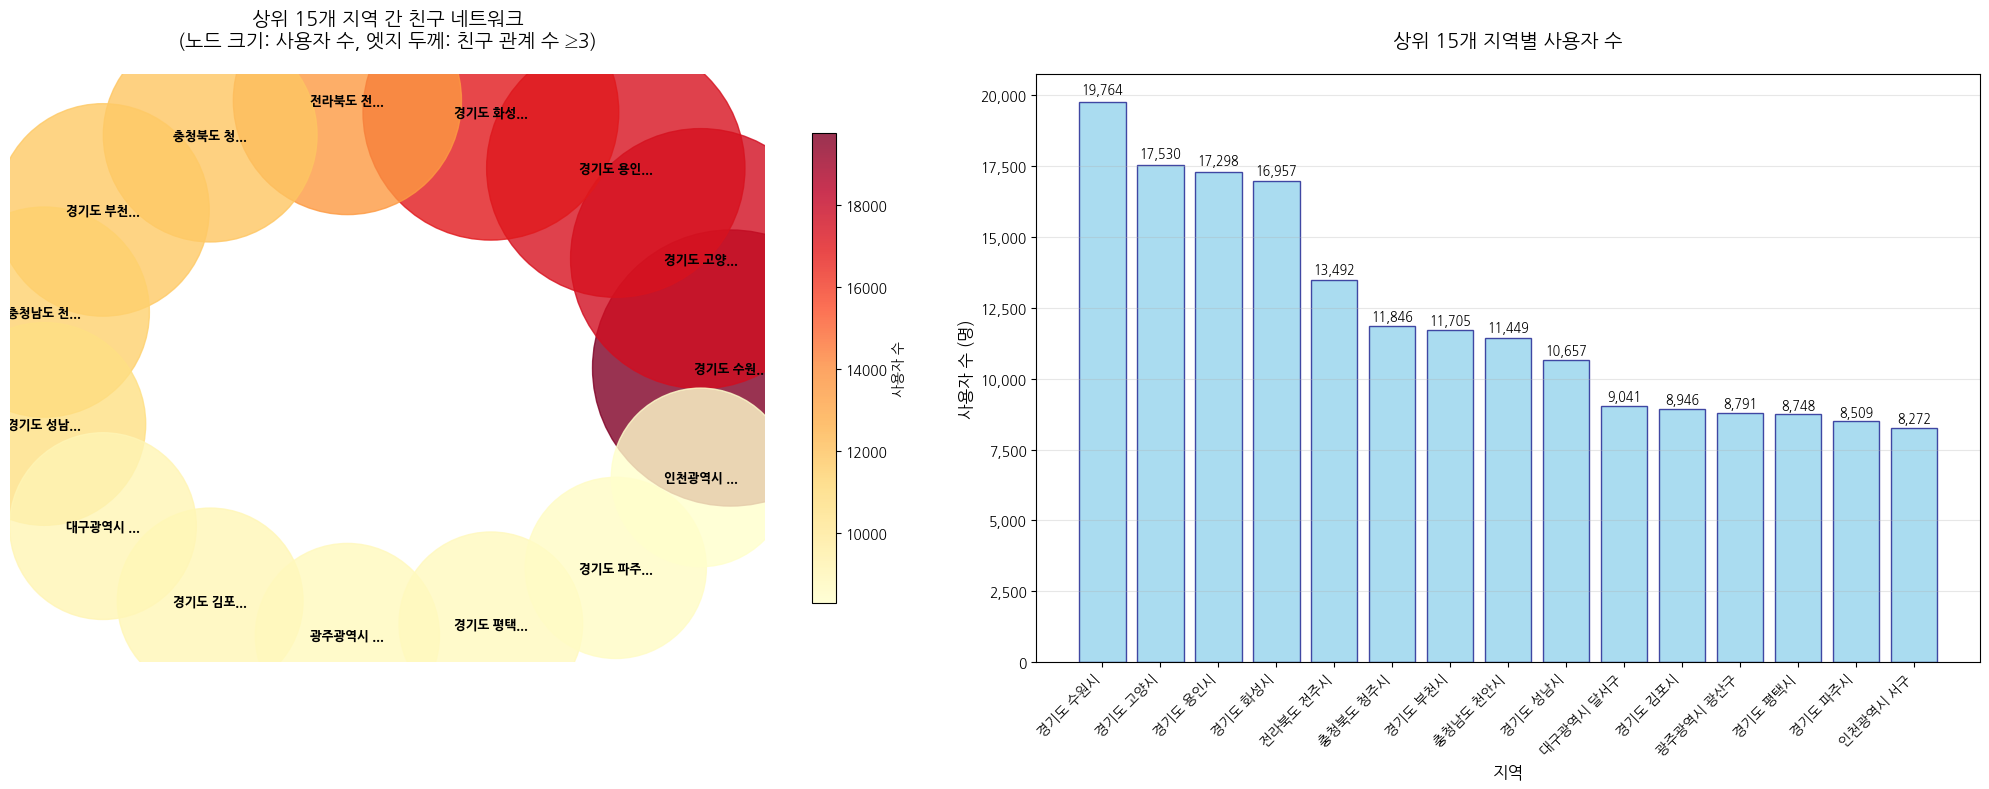


üìä ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Í≤∞Í≥º:
  ‚Ä¢ Î∂ÑÏÑù ÎåÄÏÉÅ ÏßÄÏó≠ Ïàò: 15
  ‚Ä¢ ÎÑ§Ìä∏ÏõåÌÅ¨ ÎÖ∏Îìú Ïàò: 15
  ‚Ä¢ ÏßÄÏó≠ Í∞Ñ Ïó∞Í≤∞ Ïàò: 0

üéØ ÎÑ§Ìä∏ÏõåÌÅ¨ Ï§ëÏã¨ÏÑ± Î∂ÑÏÑù:
    Ïó∞Í≤∞Îêú ÏßÄÏó≠Ïù¥ ÏóÜÏñ¥ Ï§ëÏã¨ÏÑ± Î∂ÑÏÑùÏùÑ ÏàòÌñâÌï† Ïàò ÏóÜÏäµÎãàÎã§.

‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
from collections import defaultdict
import koreanize_matplotlib

font_path = "/home/jovyan/work/data/nanum-gothic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_prop)
mpl.rcParams['axes.unicode_minus'] = False

class RegionNetworkVisualizer:
    def __init__(self):
        """
        ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî Ï†ÑÏö© ÌÅ¥ÎûòÏä§
        
        Args:
            user_data_path: ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú
        """
        print("üìä Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
        self.user_df = user
        self._preprocess_data()
        print(f"‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎî© ÏôÑÎ£å - Ï¥ù {len(self.user_df):,}Î™Ö ÏÇ¨Ïö©Ïûê")
        
    def _preprocess_data(self):
        """ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Îßå Ï†ÑÏ≤òÎ¶¨"""
        # ÏπúÍµ¨ Î¶¨Ïä§Ìä∏ ÌååÏã±
        print("üîÑ ÏπúÍµ¨ Î¶¨Ïä§Ìä∏ ÌååÏã± Ï§ë...")
        self.user_df['friend_id_list'] = self.user_df['friend_id_list'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else []
        )
        
        # ÏßÄÏó≠ Ï†ïÎ≥¥ Ï∂îÏ∂ú (Ïãú/Íµ∞/Íµ¨ÍπåÏßÄ)
        self.user_df['region'] = self.user_df['address'].apply(
            lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
        )
        
        print(f"üìç Ï¥ù ÏßÄÏó≠ Ïàò: {self.user_df['region'].nunique()}")
        
    def build_and_visualize_region_network(self, top_n=15, min_connections=3):
        """
        ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï Î∞è ÏãúÍ∞ÅÌôîÎ•º ÌïúÎ≤àÏóê ÏàòÌñâ
        
        Args:
            top_n: ÏãúÍ∞ÅÌôîÌï† ÏÉÅÏúÑ ÏßÄÏó≠ Ïàò
            min_connections: ÎÑ§Ìä∏ÏõåÌÅ¨Ïóê Ìè¨Ìï®Ìï† ÏµúÏÜå Ïó∞Í≤∞ Ïàò
        """
        print(f"\nüåê ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï Ï§ë...")
        
        # ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò Í≥ÑÏÇ∞
        region_counts = self.user_df['region'].value_counts()
        top_regions = region_counts.head(top_n).index.tolist()
        
        print(f"üìç Î∂ÑÏÑù ÎåÄÏÉÅ ÏßÄÏó≠: {', '.join(top_regions[:5])}{'...' if len(top_regions) > 5 else ''}")
        
        # ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ Ïπ¥Ïö¥Ìä∏
        print("üîó ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ Î∂ÑÏÑù Ï§ë...")
        region_connections = defaultdict(int)
        
        # ÏÉÅÏúÑ ÏßÄÏó≠ ÏÇ¨Ïö©ÏûêÎì§Îßå ÌïÑÌÑ∞ÎßÅ (ÏÜçÎèÑ Ìñ•ÏÉÅ)
        top_region_users = self.user_df[self.user_df['region'].isin(top_regions)]
        
        for _, user in top_region_users.iterrows():
            user_region = user['region']
            friends = user['friend_id_list']
            
            if len(friends) == 0:  # ÏπúÍµ¨Í∞Ä ÏóÜÏúºÎ©¥ Í±¥ÎÑàÎõ∞Í∏∞
                continue
                
            # ÏπúÍµ¨Îì§Ïùò ÏßÄÏó≠ Ï†ïÎ≥¥ ÌïúÎ≤àÏóê Ï°∞Ìöå (ÏÜçÎèÑ Ìñ•ÏÉÅ)
            friend_regions = self.user_df[
                self.user_df['user_id'].isin(friends)
            ]['region'].values
            
            for friend_region in friend_regions:
                if friend_region in top_regions and user_region != friend_region:
                    region_pair = tuple(sorted([user_region, friend_region]))
                    region_connections[region_pair] += 1
        
        # ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ Íµ¨Ï∂ï
        region_network = nx.Graph()
        
        # Ïó∞Í≤∞ Ï∂îÍ∞Ä
        for (region1, region2), weight in region_connections.items():
            if weight >= min_connections:
                region_network.add_edge(region1, region2, weight=weight)
        
        # Ïó∞Í≤∞ÎêòÏßÄ ÏïäÏùÄ ÏÉÅÏúÑ ÏßÄÏó≠Îì§ÎèÑ ÎÖ∏ÎìúÎ°ú Ï∂îÍ∞Ä
        for region in top_regions:
            if region not in region_network.nodes():
                region_network.add_node(region)
        
        print(f"‚úÖ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï ÏôÑÎ£å - ÎÖ∏Îìú: {region_network.number_of_nodes()}, Ïó£ÏßÄ: {region_network.number_of_edges()}")
        
        # ÏãúÍ∞ÅÌôî
        self._visualize_network(region_network, region_counts, region_connections, top_n, min_connections)
        
        return region_network, region_connections
    
    def _visualize_network(self, region_network, region_counts, region_connections, top_n, min_connections):
        """ÎÑ§Ìä∏ÏõåÌÅ¨ Î∞è ÌÜµÍ≥Ñ ÏãúÍ∞ÅÌôî"""
        print("üé® ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # 1. ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ
        if region_network.number_of_nodes() > 0:
            # Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï (Ïó∞Í≤∞Îêú ÎÖ∏ÎìúÍ∞Ä ÏûàÏùÑ ÎïåÎßå)
            if region_network.number_of_edges() > 0:
                pos = nx.spring_layout(region_network, k=3, iterations=50, seed=42)
            else:
                # Ïó∞Í≤∞Ïù¥ ÏóÜÏúºÎ©¥ ÏõêÌòï Î∞∞Ïπò
                pos = nx.circular_layout(region_network)
            
            # ÎÖ∏Îìú ÌÅ¨Í∏∞ÏôÄ ÏÉâÏÉÅ: ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê ÏàòÏóê ÎπÑÎ°Ä
            node_sizes = []
            node_colors = []
            node_labels = {}
            
            for node in region_network.nodes():
                user_count = region_counts.get(node, 0)
                node_sizes.append(max(user_count * 2, 300))  # ÏµúÏÜå ÌÅ¨Í∏∞ Î≥¥Ïû•
                node_colors.append(user_count)
                # Í∏¥ ÏßÄÏó≠Î™Ö Ï§ÑÏù¥Í∏∞
                if len(node) > 6:
                    node_labels[node] = node[:6] + '...'
                else:
                    node_labels[node] = node
            
            # ÎÖ∏Îìú Í∑∏Î¶¨Í∏∞
            if len(node_colors) > 1:  # ÏÉâÏÉÅ Î≤îÏúÑÍ∞Ä ÏûàÏùÑ ÎïåÎßå Ïª¨Îü¨Îßµ ÏÇ¨Ïö©
                nodes = nx.draw_networkx_nodes(
                    region_network, pos,
                    node_size=node_sizes,
                    node_color=node_colors,
                    cmap='YlOrRd',
                    alpha=0.8,
                    ax=ax1
                )
                # Ïª¨Îü¨Î∞î Ï∂îÍ∞Ä
                plt.colorbar(nodes, ax=ax1, label='ÏÇ¨Ïö©Ïûê Ïàò', shrink=0.8)
            else:
                nx.draw_networkx_nodes(
                    region_network, pos,
                    node_size=node_sizes,
                    node_color='lightblue',
                    alpha=0.8,
                    ax=ax1
                )
            
            # Ïó£ÏßÄ Í∑∏Î¶¨Í∏∞ (Ïó∞Í≤∞Ïù¥ ÏûàÏùÑ ÎïåÎßå)
            if region_network.number_of_edges() > 0:
                edge_widths = []
                edge_colors = []
                
                for u, v in region_network.edges():
                    weight = region_network[u][v]['weight']
                    edge_widths.append(max(weight * 0.1, 1))  # ÏµúÏÜå ÎëêÍªò Î≥¥Ïû•
                    edge_colors.append(weight)
                
                nx.draw_networkx_edges(
                    region_network, pos,
                    width=edge_widths,
                    edge_color=edge_colors,
                    edge_cmap='Blues',
                    alpha=0.6,
                    ax=ax1
                )
            
            # ÎùºÎ≤® Í∑∏Î¶¨Í∏∞
            nx.draw_networkx_labels(
                region_network, pos,
                labels=node_labels,
                font_size=9,
                font_weight='bold',
                font_family=font_prop,
                ax=ax1
            )
            
            ax1.set_title(f'ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ ÎÑ§Ìä∏ÏõåÌÅ¨\n(ÎÖ∏Îìú ÌÅ¨Í∏∞: ÏÇ¨Ïö©Ïûê Ïàò, Ïó£ÏßÄ ÎëêÍªò: ÏπúÍµ¨ Í¥ÄÍ≥Ñ Ïàò ‚â•{min_connections})', 
                         fontsize=14, pad=20)
        else:
            ax1.text(0.5, 0.5, 'ÌëúÏãúÌï† ÎÑ§Ìä∏ÏõåÌÅ¨Í∞Ä ÏóÜÏäµÎãàÎã§', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=16)
            ax1.set_title(f'ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨', fontsize=14)
        
        ax1.axis('off')
        
        # 2. ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò ÎßâÎåÄ Í∑∏ÎûòÌîÑ
        top_region_counts = region_counts.head(top_n)
        bars = ax2.bar(range(len(top_region_counts)), top_region_counts.values,
                      color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1)
        
        ax2.set_title(f'ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò', fontsize=14, pad=20)
        ax2.set_xlabel('ÏßÄÏó≠', fontsize=12)
        ax2.set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò (Î™Ö)', fontsize=12)
        ax2.set_xticks(range(len(top_region_counts)))
        ax2.set_xticklabels(top_region_counts.index, rotation=45, ha='right')
        
        # ÎßâÎåÄ ÏúÑÏóê ÏàòÏπò ÌëúÏãú
        for i, (bar, value) in enumerate(zip(bars, top_region_counts.values)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
        
        ax2.grid(axis='y', alpha=0.3)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
        
        plt.tight_layout()
        plt.show()
        
        # ÌÜµÍ≥Ñ Ï∂úÎ†•
        self._print_statistics(region_network, region_connections, top_n)
    
    def _print_statistics(self, region_network, region_connections, top_n):
        """ÎÑ§Ìä∏ÏõåÌÅ¨ ÌÜµÍ≥Ñ Ï∂úÎ†•"""
        print(f"\nüìä ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Í≤∞Í≥º:")
        print(f"  ‚Ä¢ Î∂ÑÏÑù ÎåÄÏÉÅ ÏßÄÏó≠ Ïàò: {top_n}")
        print(f"  ‚Ä¢ ÎÑ§Ìä∏ÏõåÌÅ¨ ÎÖ∏Îìú Ïàò: {region_network.number_of_nodes()}")
        print(f"  ‚Ä¢ ÏßÄÏó≠ Í∞Ñ Ïó∞Í≤∞ Ïàò: {region_network.number_of_edges()}")
        
        if region_connections:
            print(f"\nüîó Ï£ºÏöî ÏßÄÏó≠ Í∞Ñ ÏπúÍµ¨ Í¥ÄÍ≥Ñ (ÏÉÅÏúÑ 10Í∞ú):")
            sorted_connections = sorted(region_connections.items(), key=lambda x: x[1], reverse=True)
            for i, ((region1, region2), count) in enumerate(sorted_connections[:10]):
                print(f"  {i+1:2d}. {region1} ‚Üî {region2}: {count:,}Í∞ú")
        
        if region_network.number_of_nodes() > 0:
            # ÎÑ§Ìä∏ÏõåÌÅ¨ Ï§ëÏã¨ÏÑ± Î∂ÑÏÑù
            print(f"\nüéØ ÎÑ§Ìä∏ÏõåÌÅ¨ Ï§ëÏã¨ÏÑ± Î∂ÑÏÑù:")
            
            if region_network.number_of_edges() > 0:
                # Ïó∞Í≤∞ Ï§ëÏã¨ÏÑ± (Degree Centrality)
                degree_centrality = nx.degree_centrality(region_network)
                top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
                
                print("  Ïó∞Í≤∞ Ï§ëÏã¨ÏÑ± ÏÉÅÏúÑ 5Í∞ú ÏßÄÏó≠:")
                for region, centrality in top_degree:
                    user_count = len(self.user_df[self.user_df['region'] == region])
                    print(f"    ‚Ä¢ {region}: {centrality:.3f} (ÏÇ¨Ïö©Ïûê {user_count:,}Î™Ö)")
            else:
                print("    Ïó∞Í≤∞Îêú ÏßÄÏó≠Ïù¥ ÏóÜÏñ¥ Ï§ëÏã¨ÏÑ± Î∂ÑÏÑùÏùÑ ÏàòÌñâÌï† Ïàò ÏóÜÏäµÎãàÎã§.")

def main():
    """Î©îÏù∏ Ïã§Ìñâ Ìï®Ïàò"""
    print("üöÄ ÏßÄÏó≠ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏãúÍ∞ÅÌôî ÏãúÏûë!")
    
    # ÏãúÍ∞ÅÌôî Ïã§Ìñâ
    visualizer = RegionNetworkVisualizer()
    
    # ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï∂ï Î∞è ÏãúÍ∞ÅÌôî
    network, connections = visualizer.build_and_visualize_region_network(
        top_n=15,           # ÏÉÅÏúÑ 15Í∞ú ÏßÄÏó≠
        min_connections=3   # ÏµúÏÜå 3Í∞ú ÏπúÍµ¨ Í¥ÄÍ≥Ñ
    )
    
    print("\n‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!")
    return visualizer, network, connections

# Í∞úÎ≥Ñ Ìï®ÏàòÎì§ (ÌïÑÏöîÏãú ÏÇ¨Ïö©)
def quick_visualize(top_regions=15, min_conn=3):
    """Îπ†Î•∏ ÏãúÍ∞ÅÌôî Ìï®Ïàò"""
    viz = RegionNetworkVisualizer()
    return viz.build_and_visualize_region_network(top_regions, min_conn)

def get_region_stats(top_n=20):
    """ÏßÄÏó≠Î≥Ñ Í∏∞Î≥∏ ÌÜµÍ≥ÑÎßå ÌôïÏù∏"""
    df = user
    df['region'] = df['address'].apply(
        lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
    )
    
    region_counts = df['region'].value_counts().head(top_n)
    print(f"üìç ÏÉÅÏúÑ {top_n}Í∞ú ÏßÄÏó≠Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò:")
    for i, (region, count) in enumerate(region_counts.items(), 1):
        print(f"  {i:2d}. {region}: {count:,}Î™Ö")
    
    return region_counts

if __name__ == "__main__":
    # Ïã§Ìñâ Î∞©Î≤ï 1: Ï†ÑÏ≤¥ Î∂ÑÏÑù
    # visualizer, network, connections = main()
    
    # Ïã§Ìñâ Î∞©Î≤ï 2: Îπ†Î•∏ ÏãúÍ∞ÅÌôîÎßå
    quick_visualize(top_regions=10, min_conn=5)
    
    # Ïã§Ìñâ Î∞©Î≤ï 3: Í∏∞Î≥∏ ÌÜµÍ≥ÑÎßå ÌôïÏù∏
    # get_region_stats('user_data.csv', top_n=15)

In [38]:
accounts_user_contacts = pd.read_csv('/home/jovyan/work/data/accounts_user_contacts.csv')
accounts_user_contacts['invite_user_id_list'] = accounts_user_contacts['invite_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_contacts['invite_len'] = accounts_user_contacts['invite_user_id_list'].apply(len)
accounts_user_contacts[['user_id','invite_user_id_list','invite_len']].head()

user_id invite_user_id_list  invite_len
0  1167696                  []           0
1   863169                  []           0
2   857205            [854615]           1
3   851431                  []           0
4   855476            [849318]           1

-> Í¥ÄÎ†® Ï∂îÍ∞Ä Î∂ÑÏÑùÏùÄ Î≥ÑÎèÑ ÌååÏùºÏóêÏÑú ÏßÑÌñâ (jihyun_nx.ipynb)

### 3. ÏÑúÎπÑÏä§ Ïù¥ÌÉà Ìå®ÌÑ¥ ÌôïÏù∏

#### Ï≤´ Ïù¥ÌÉà ÏãúÏ†ê

In [ ]:
withdraw_df = pd.read_csv("accounts_userwithdraw.csv", parse_dates=["created_at"])  # ÌÉàÌá¥ Í∏∞Î°ù
user_df = pd.read_csv("/home/jovyan/work/data/user.csv", parse_dates=["first_created_at"])

# Í∞ÄÏûÖ ÌõÑ Ïù¥ÌÉàÍπåÏßÄ ÏÜåÏöî ÏùºÏàò
withdraw_merged = pd.merge(user_df, withdraw_df, on="user_id")
withdraw_merged["Ïù¥ÌÉàÍπåÏßÄ_ÏùºÏàò"] = (withdraw_merged["created_at"] - withdraw_merged["first_created_at"]).dt.days

In [ ]:
until_withdraw_days = withdraw_merged.sort_values("Ïù¥ÌÉàÍπåÏßÄ_ÏùºÏàò", ascending=False)
until_withdraw_days.plot(kind='barh', title='Ïò§Îûò Î≤ÑÌã¥ Ïú†Ï†Ä ÏàúÏÑú', figsize=(8, 6))
plt.show()

#### Ïù¥ÌÉà ÏßÅÏ†Ñ ÌñâÎèô

In [ ]:
withdraw_action = withdraw_merged.groupby("last_created_at_table").count().reset_index()
withdraw_action = withdraw_action.sort_values("count", ascending=False)
withdraw_action.plot(kind='barh', title='Ïù¥ÌÉà ÏßÅÏ†Ñ ÌñâÎèô', figsize=(8, 6))
plt.show()

#### ÎåÄÎüâ Ïù¥ÌÉà ÏãúÏ†ê

In [ ]:
last_activity = user_df.groupby("user_id")["created_at"].max().reset_index()
last_activity.columns = ["user_id", "ÎßàÏßÄÎßâ_ÌôúÎèô"]

# Ïù¥ÌÉàÍ≥º Ìï®Íªò Î≥ëÌï©
withdraw_full = pd.merge(withdraw_merged, last_activity, on="user_id", how="left")
withdraw_full["Ïù¥ÌÉà_Ï†Ñ_ÌôúÎèô_Í∞ÑÍ≤©"] = (withdraw_full["created_at"] - withdraw_full["ÎßàÏßÄÎßâ_ÌôúÎèô"]).dt.days

#### ÏπúÍµ¨Ïùò Ïù¥ÌÉàÏù¥ ÏòÅÌñ•ÏùÑ Ï£ºÏóàÎÇò

In [ ]:
# Ïú†Ï†ÄÎ≥Ñ ÏπúÍµ¨ Î¶¨Ïä§Ìä∏Î•º explode
user_friends = user_df[["user_id", "friend_id_list"]].copy()
user_friends["friend_id_list"] = user_friends["friend_id_list"].apply(eval)  # str -> list
user_friends_exploded = user_friends.explode("friend_id_list").rename(columns={"friend_id_list": "friend_id"})

# ÏπúÍµ¨ Ïù¥ÌÉà Ïó¨Î∂ÄÏôÄ ÎÇ†Ïßú join
friend_withdraw = withdraw_df.rename(columns={"user_id": "friend_id", "withdraw_date": "friend_withdraw_date"})
user_with_friend_status = pd.merge(user_friends_exploded, friend_withdraw, on="friend_id", how="left")

# Ïú†Ï†ÄÎ≥Ñ ÏπúÍµ¨ Ïù¥ÌÉà ÏãúÏ†ê ÌèâÍ∑†
friend_influence = user_with_friend_status.groupby("user_id")["friend_withdraw_date"].min().reset_index()
withdraw_final = pd.merge(withdraw_merged, friend_influence, on="user_id", how="left")
withdraw_final["ÏπúÍµ¨_Î®ºÏ†Ä_Ïù¥ÌÉà"] = withdraw_final["friend_withdraw_date"] < withdraw_final["withdraw_date"]